In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
from green_solver import *
from scipy.fft import rfft, rfftfreq
from scipy.signal import welch

plt.rcParams.update({
    'font.size': 14,             # Default text size
    'axes.labelsize': 24,        # Axis label size
    'axes.titlesize': 18,        # Title size
    'xtick.labelsize': 16,       # X tick label size
    'ytick.labelsize': 16,       # Y tick label size
    'legend.fontsize': 10,       # Legend text size
    'figure.titlesize': 20,      # Figure title size
})


from matplotlib.offsetbox import AnchoredText


def add_baw_info_box(
    ax,
    baw,
    *,
    # -----------------------------
    # BAW toggles (match your class)
    # -----------------------------
    show_n=False,
    show_d=False,
    show_eta=False,            # eta_x, eta_y
    show_omega_lambda=False,
    show_f_lambda=True,
    show_Q=True,
    show_gamma_lambda=False,   # uses baw.gamma_lambda
    show_tau=True,
    show_k_lambda=False,

    # -----------------------------
    # Drive toggles
    # -----------------------------
    show_drive=False,
    show_detuning=True,        # only for single-tone
    show_duration=False,       # adds T (chirp or single-tone)

    # -----------------------------
    # Drive inputs
    # -----------------------------
    f_drive_hz=None,           # single-tone
    f_start_hz=None,           # chirp start
    f_end_hz=None,             # chirp end
    T=None,                    # duration (s)

    # -----------------------------
    # Styling
    # -----------------------------
    loc="upper right",
    fontsize=11,
    alpha=0.85,
    boxstyle="round,pad=0.3",
    sep=" | ",                 # mathtext-safe; avoid \quad
):
    """
    Compact info box for your BAWMode object + optional drive info.
    Uses only attributes present in your class:
        n, d, eta_x, eta_y, omega_lambda, Q, k_lambda, gamma_lambda
    """
    parts = [r"$\bf{BAW:}$"]

    omega_l = baw.omega_lambda
    f_l = omega_l / (2*np.pi)

    if show_n:
        parts.append(rf"$n={baw.n}$")
    if show_d:
        parts.append(rf"$d={baw.d*1e3:.3g}\ \mathrm{{mm}}$")
    if show_eta:
        if np.isclose(baw.eta_x, baw.eta_y):
            parts.append(rf"$\eta_x=\eta_y={baw.eta_x:.3g}$")
        else:
            parts.append(rf"$\eta_x={baw.eta_x:.3g},\ \eta_y={baw.eta_y:.3g}$")

    if show_omega_lambda:
        parts.append(rf"$\omega_\lambda={omega_l:.6g}\ \mathrm{{rad/s}}$")
    if show_f_lambda:
        parts.append(rf"$\omega_\lambda/2\pi={f_l*1e-6:.6g}\ \mathrm{{MHz}}$")
    if show_Q:
        parts.append(rf"$Q={baw.Q:.2g}$")
    if show_gamma_lambda:
        # your class uses gamma_lambda = omega_lambda / Q
        parts.append(rf"$\gamma_\lambda={baw.gamma_lambda:.3g}\ \mathrm{{Hz}}$")
    if show_tau:
        # your class uses gamma_lambda = omega_lambda / Q
        parts.append(rf"$\tau={1/baw.gamma_lambda:.2e}\ \mathrm{{s}}$")
    if show_k_lambda:
        parts.append(rf"$k_\lambda={baw.k_lambda:.2g}$")

    # ---- Drive info ----
    if show_drive:
        parts.append(r"$\bf{Drive:}$")

        # Chirp
        if (f_start_hz is not None) and (f_end_hz is not None):
            parts.append(
                rf"$f_d:{f_start_hz*1e-6:.6g}\!\rightarrow\!{f_end_hz*1e-6:.6g}\ \mathrm{{MHz}}$"
            )
            if show_duration and (T is not None):
                parts.append(rf"$T={T*1e6:.3g}\ \mu s$")

        # Single-tone
        elif f_drive_hz is not None:
            parts.append(rf"$f_d={f_drive_hz*1e-6:.6g}\ \mathrm{{MHz}}$")
            if show_detuning:
                df = f_drive_hz - f_l
                parts.append(rf"$\Delta f={df*1e-3:.2g}\ \mathrm{{kHz}}$")
            if show_duration and (T is not None):
                parts.append(rf"$T={T*1e6:.3g}\ \mu s$")

    text = sep.join(parts)

    at = AnchoredText(text, loc=loc, prop=dict(size=fontsize), frameon=True)
    at.patch.set_boxstyle(boxstyle)
    at.patch.set_alpha(alpha)
    at.patch.set_linewidth(0.8)
    ax.add_artist(at)
    return at


# Sanity checks 

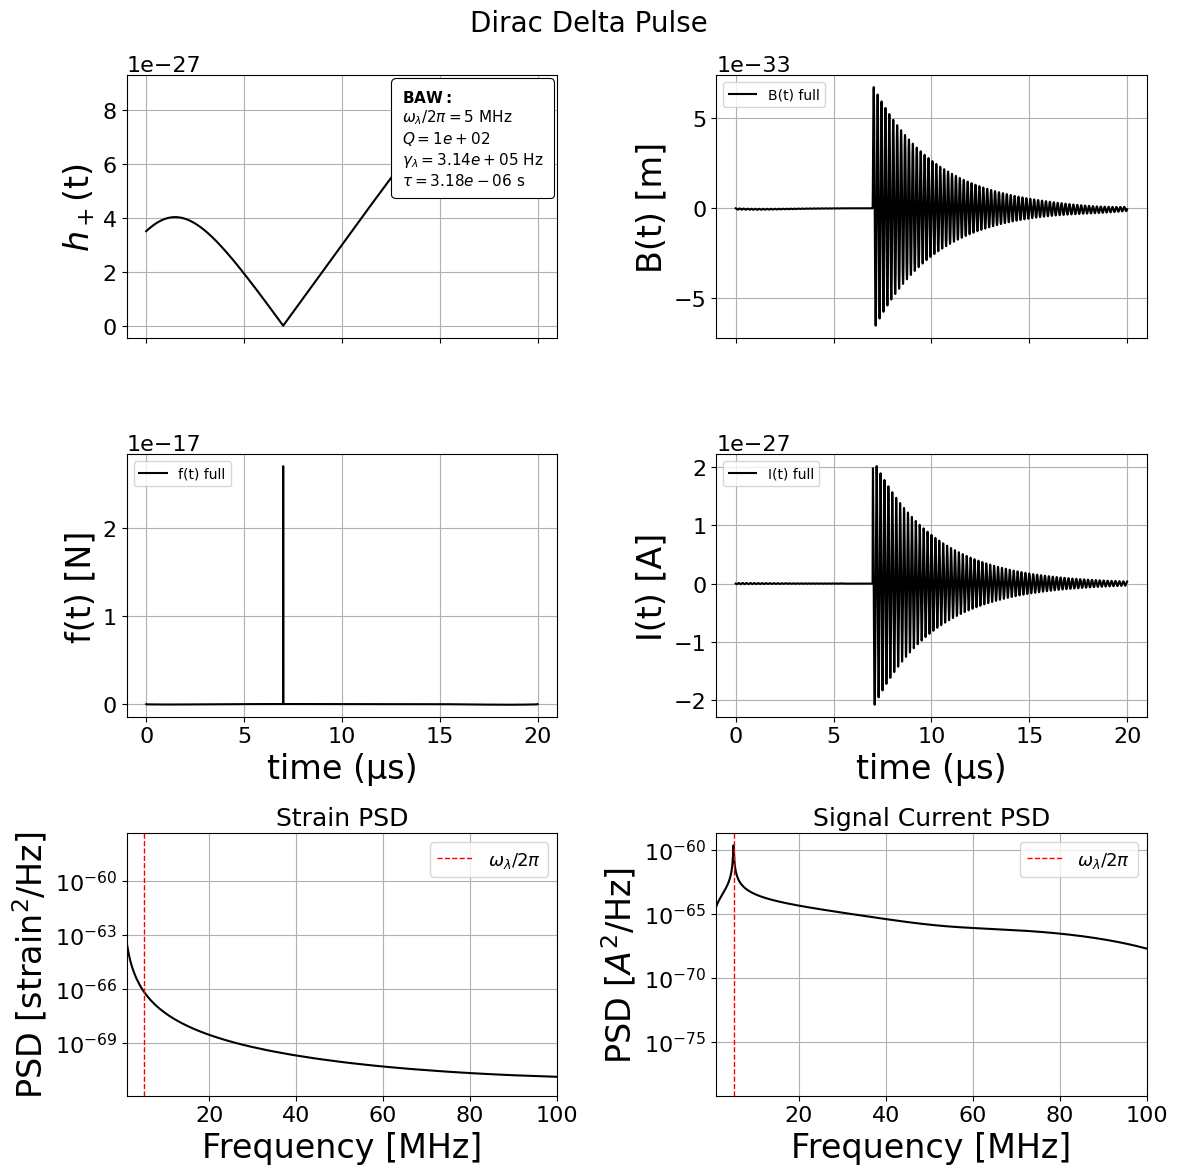

In [111]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e2,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = f0 * 1.0   # Detuning

h0 = 1e-21


# Gaussian pulse
t_center = 7e-6
sigma_t = 3e-6 # s
window =np.abs(t - t_center) * 0.5*(1 + np.tanh((t - t[0])/sigma_t)) * 0.5*(1 - np.tanh((t - t[-1])/sigma_t))
# window = np.abs(t-t_center)#np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window #* np.cos(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Dirac Delta Pulse")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=False, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force_env_ref,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)



axs[2,0].plot(freq/1e6, Shh, color='k')

axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,100)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=1, label=r'$\omega_\lambda/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,100)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=1, label=r'$\omega_\lambda/2\pi$')

axs[2,1].set_yscale('log')
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/delta_pulse.png')

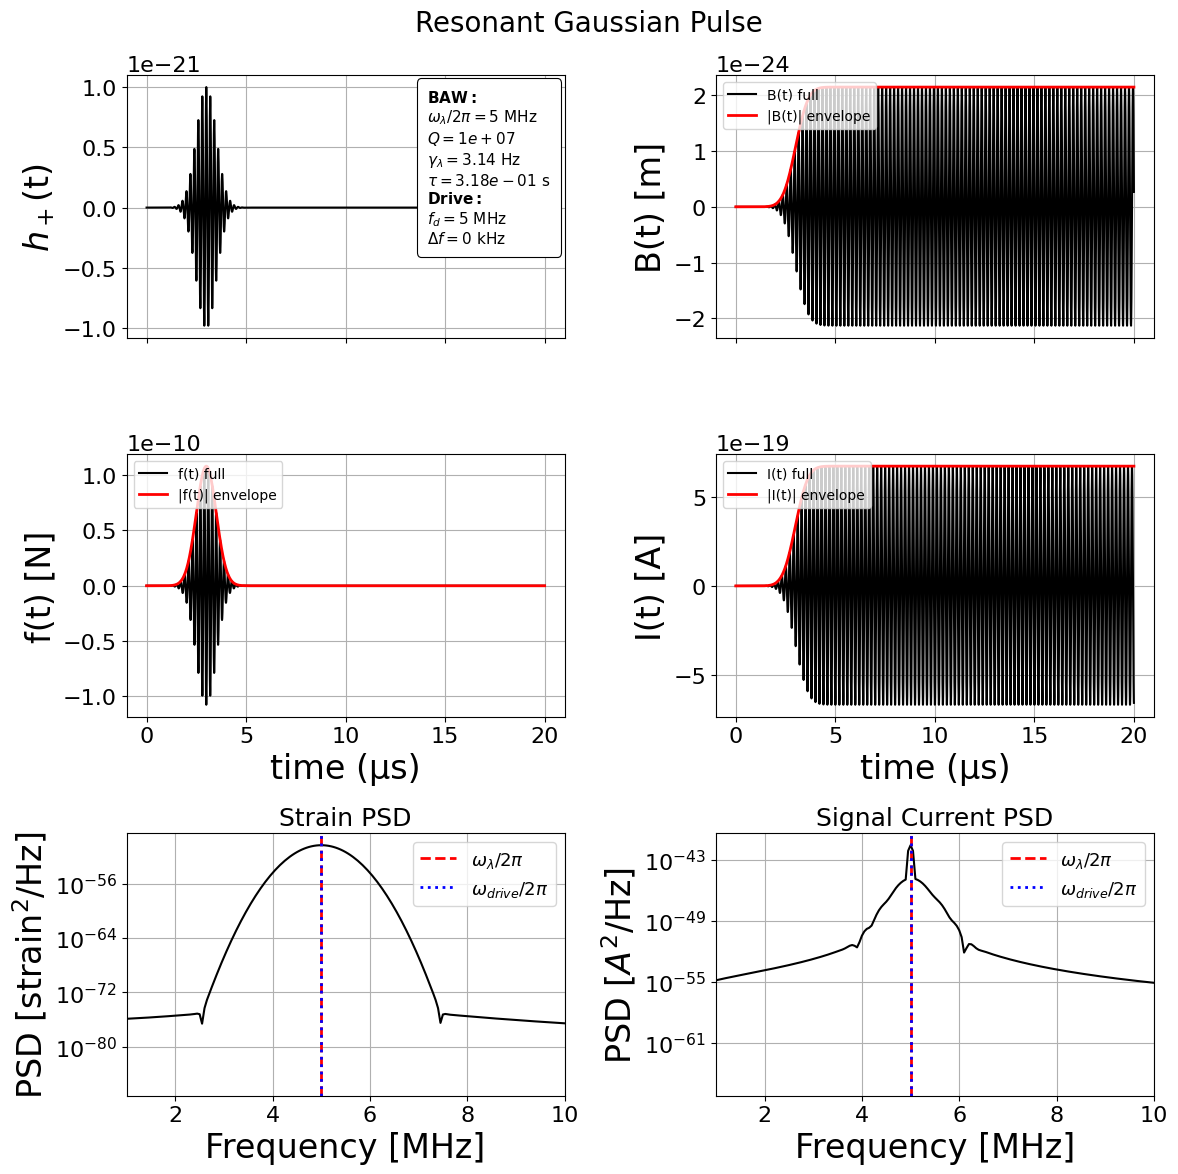

In [101]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = f0 * 1.0   # Detuning

h0 = 1e-21


# Gaussian pulse
t_center = 3e-6
sigma_t = 5e-7 # s
window = np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Resonant Gaussian Pulse")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force_env_ref,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)



axs[2,0].plot(freq/1e6, Shh, color='k')
# ax_twin = axs[2,0].twinx()
# ax_twin.plot(freq/1e6, Sff, color='r', ls=':')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,10)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')

axs[2,1].set_yscale('log')
# axs[2,1].set_xlim(3,8)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/gaussian_pulse_resonant.png')

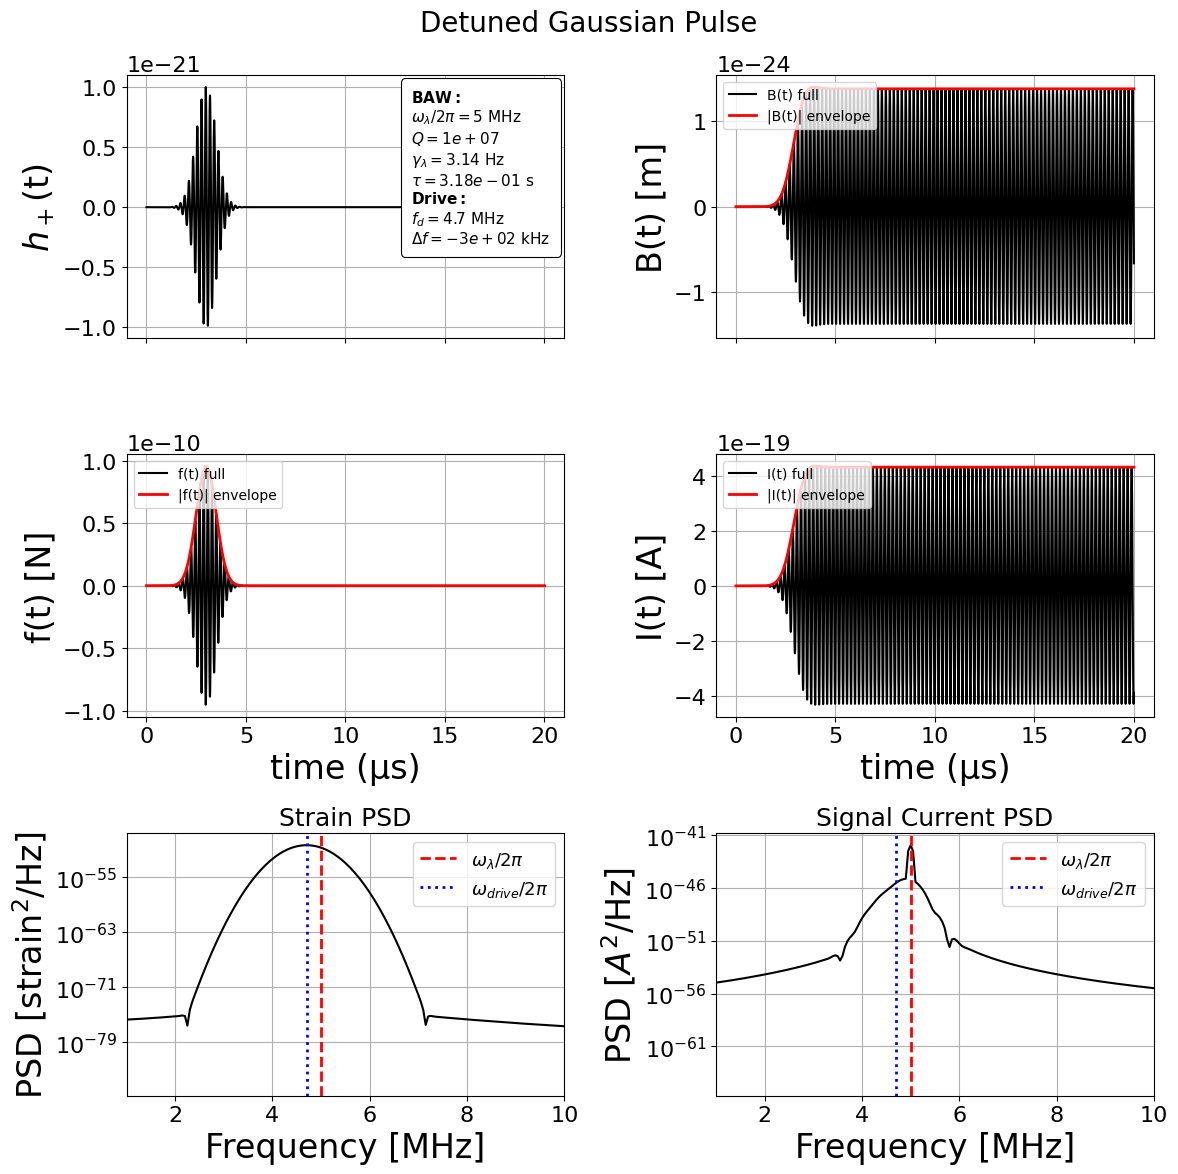

In [131]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = 4.7e6   # Detuning

h0 = 1e-21


# Gaussian pulse
t_center = 3e-6
sigma_t = 5e-7 # s
window = np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Detuned Gaussian Pulse")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force_env_ref,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)



axs[2,0].plot(freq/1e6, Shh, color='k')
# ax_twin = axs[2,0].twinx()
# ax_twin.plot(freq/1e6, Sff, color='r', ls=':')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,10)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')

axs[2,1].set_yscale('log')
# axs[2,1].set_xlim(3,8)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/gaussian_pulse_detuned.png')

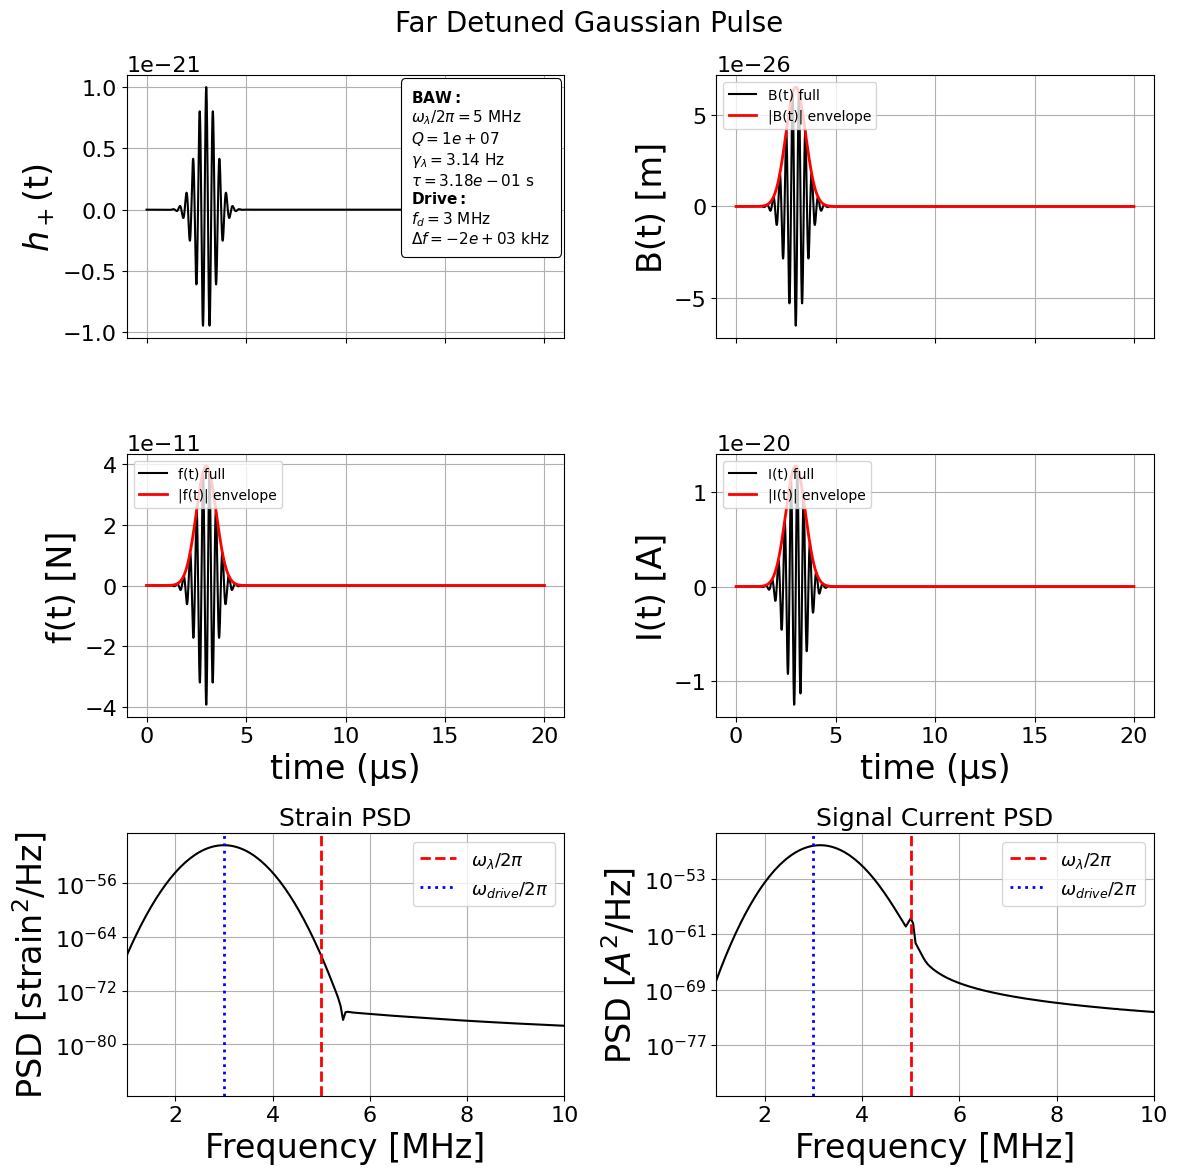

In [132]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = 3e6   # Detuning

h0 = 1e-21


# Gaussian pulse
t_center = 3e-6
sigma_t = 5e-7 # s
window = np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Far Detuned Gaussian Pulse")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force_env_ref,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)



axs[2,0].plot(freq/1e6, Shh, color='k')
# ax_twin = axs[2,0].twinx()
# ax_twin.plot(freq/1e6, Sff, color='r', ls=':')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,10)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')

axs[2,1].set_yscale('log')
# axs[2,1].set_xlim(3,8)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/gaussian_pulse_far_detuned.png')

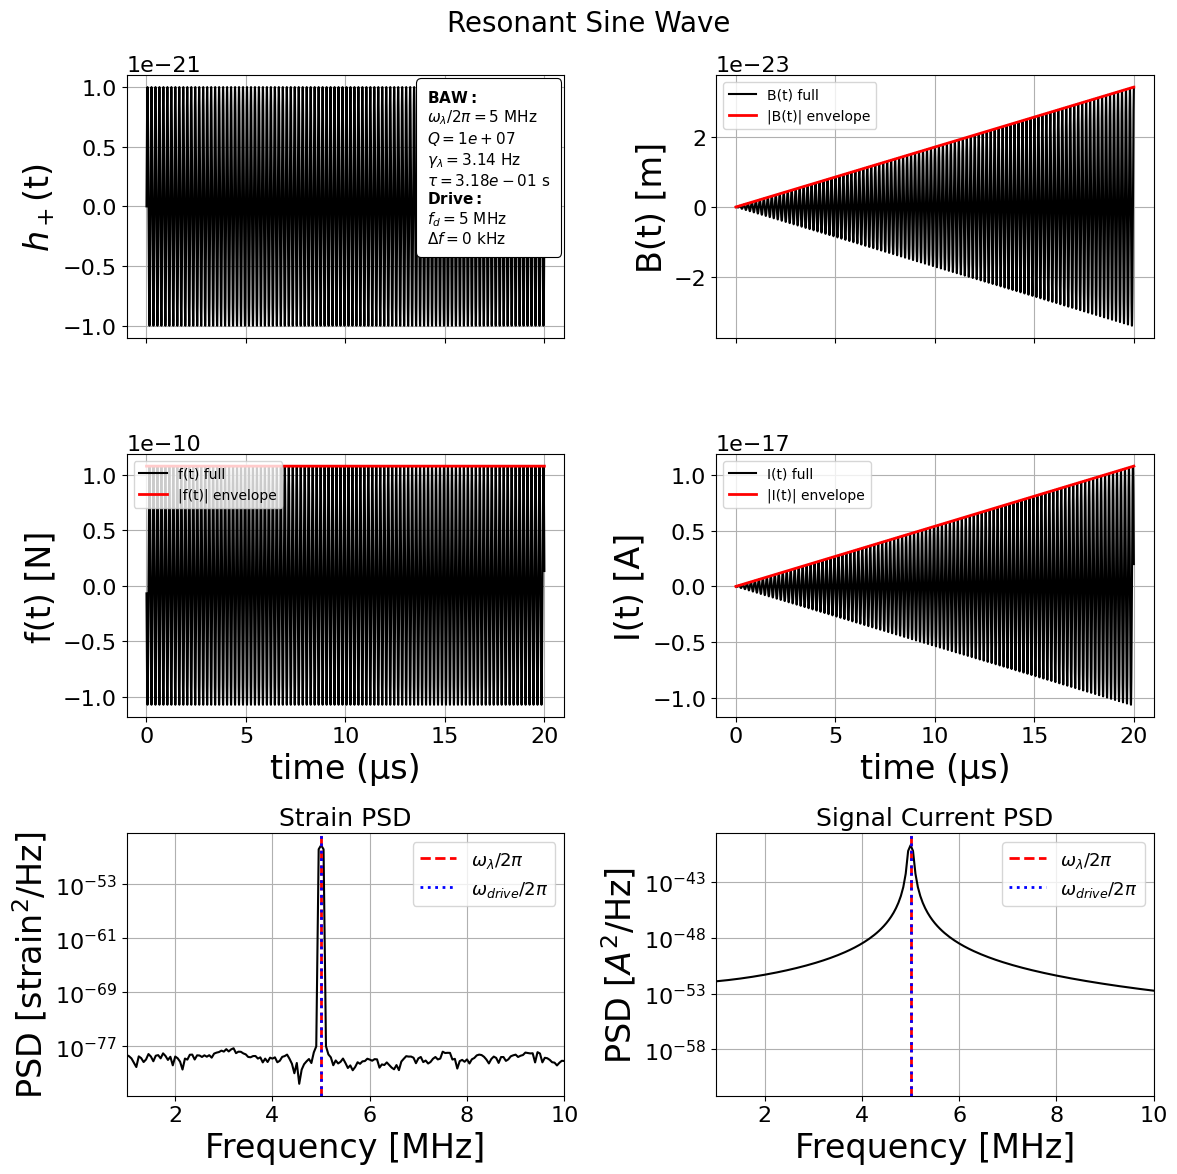

In [124]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = f0 * 1.   # Detuning

h0 = 1e-21


# Gaussian pulse
t_center = 3e-6
sigma_t = 5e-7 # s
window = np.ones_like(t)#np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window * np.sin(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Resonant Sine Wave")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force_env_ref,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)



axs[2,0].plot(freq/1e6, Shh, color='k')
# ax_twin = axs[2,0].twinx()
# ax_twin.plot(freq/1e6, Sff, color='r', ls=':')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,10)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')

axs[2,1].set_yscale('log')
# axs[2,1].set_xlim(3,8)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/sine_wave_resonant.png')

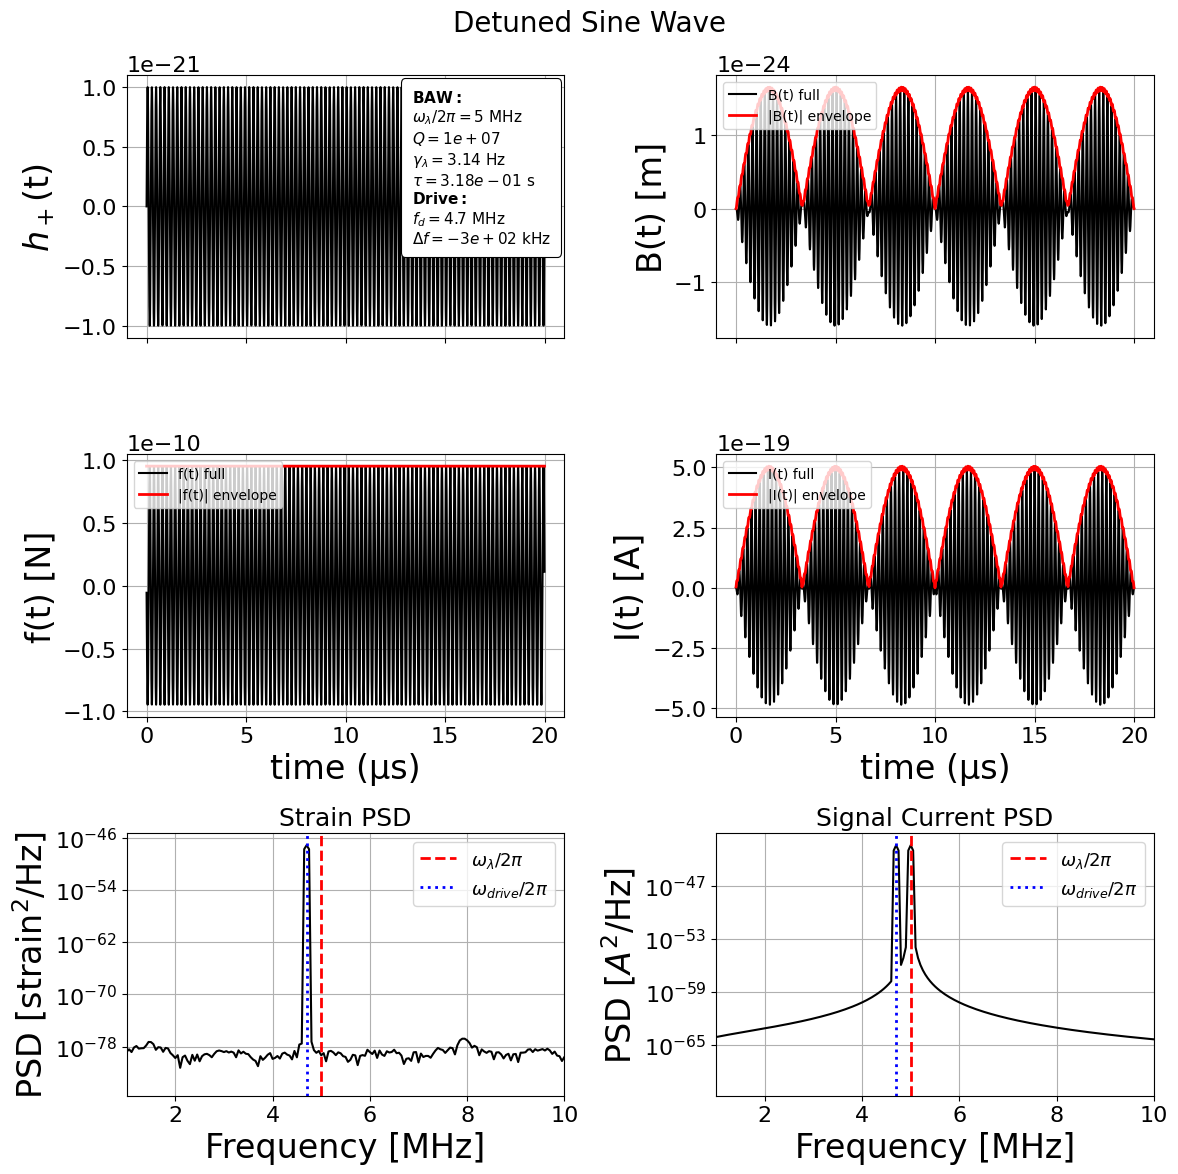

In [154]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = 4.7e6   # Detuning

h0 = 1e-21


# Gaussian pulse
t_center = 3e-6
sigma_t = 5e-7 # s
window = np.ones_like(t)#np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window * np.sin(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Detuned Sine Wave")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force_env_ref,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)



axs[2,0].plot(freq/1e6, Shh, color='k')
# ax_twin = axs[2,0].twinx()
# ax_twin.plot(freq/1e6, Sff, color='r', ls=':')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,10)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')

axs[2,1].set_yscale('log')
# axs[2,1].set_xlim(3,8)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/sine_wave_detuned.png')




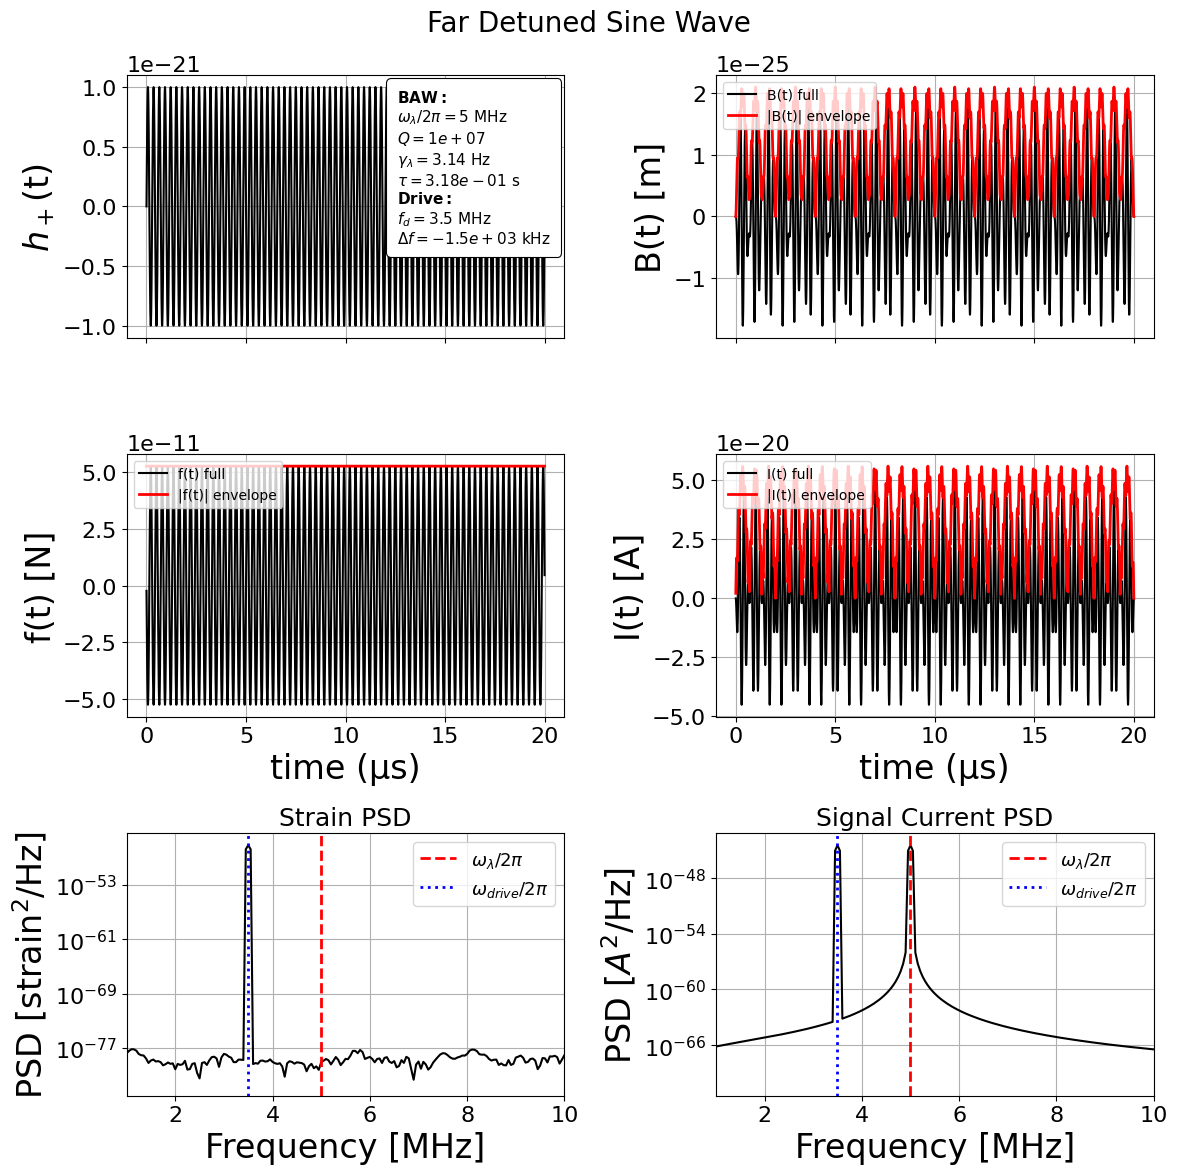

In [155]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = 3.5e6   # Detuning

h0 = 1e-21


# Gaussian pulse
t_center = 3e-6
sigma_t = 5e-7 # s
window = np.ones_like(t)#np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window * np.sin(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Far Detuned Sine Wave")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)





axs[2,0].plot(freq/1e6, Shh, color='k')
# ax_twin = axs[2,0].twinx()
# ax_twin.plot(freq/1e6, Sff, color='r', ls=':')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,10)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')

axs[2,1].set_yscale('log')
# axs[2,1].set_xlim(3,8)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/sine_wave_far_detuned.png')

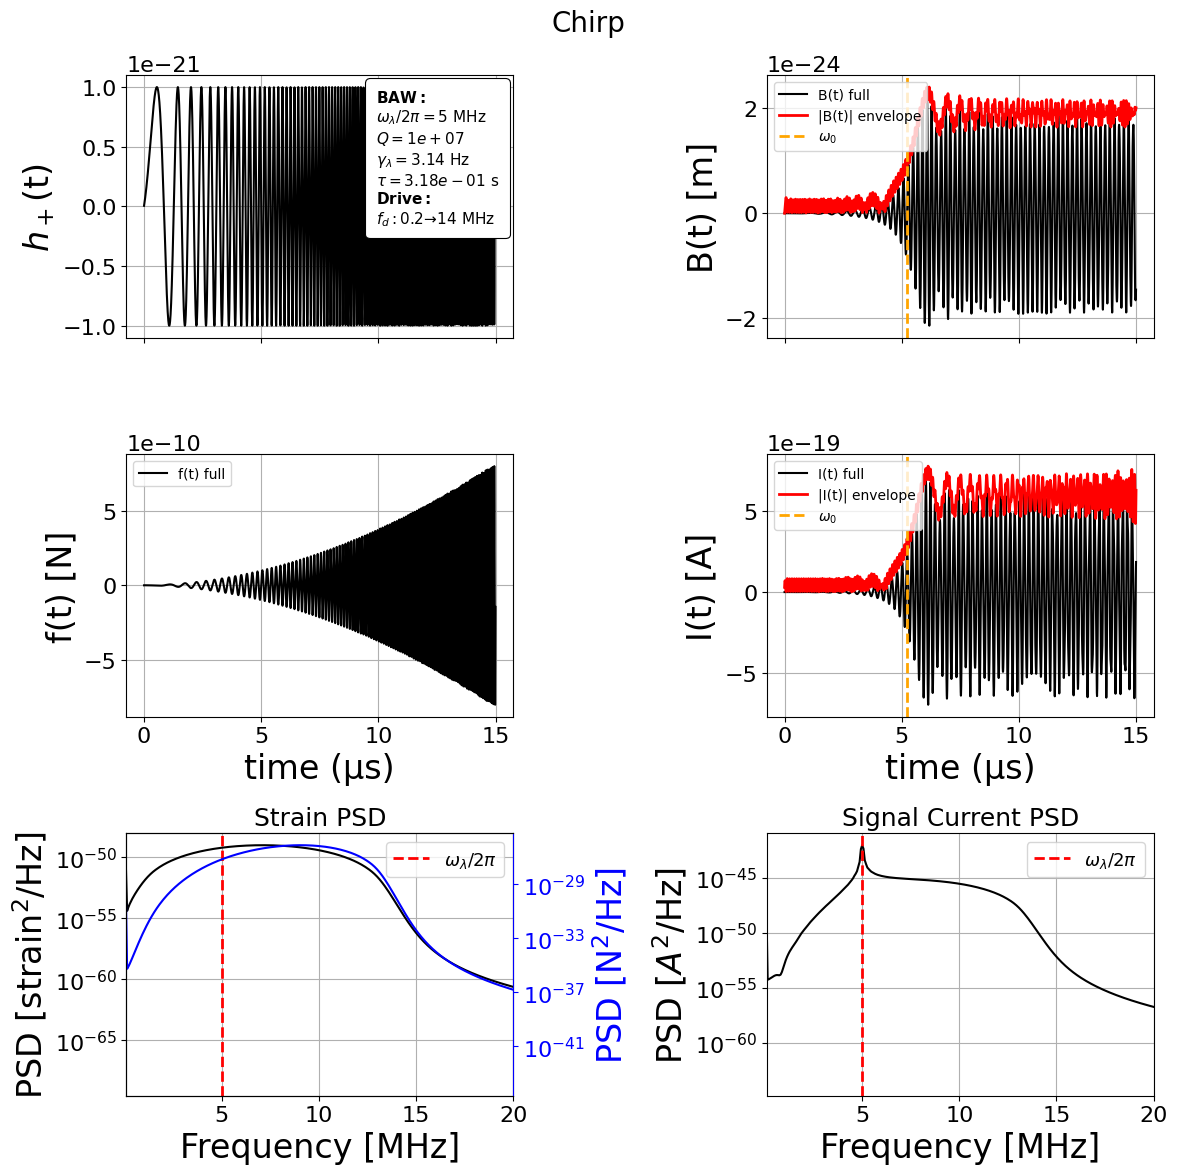

In [196]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 15e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)

h0 = 1e-21

f_start=0.2e6
f_end=14e6
# Chirp
window = np.ones_like(t)
#0.5*(1 + np.tanh((t - t[0])/sigma_t)) * 0.5*(1 - np.tanh((t - t[-1])/sigma_t))
h_plus, f_t = chirp_with_window(t, f_start=f_start, f_end=f_end, t_start=t[0], t_end=t[-1], envelope=window*h0,phi0=-np.pi/2)
omega_d_of_t = 2*np.pi* f_t * np.ones_like(t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=omega_d_of_t,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Chirp")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
# axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].axvline(t_f0[0]*1e6, color='orange', lw=2, ls='--', label=r'$\omega_0$')
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].axvline(t_f0[0]*1e6, color='orange', lw=2, ls='--', label=r'$\omega_0$')
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_start_hz=f_start, f_end_hz=f_end, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

t_f0 = time_at_frequency(t, omega_d_of_t, [baw.omega_lambda - baw.gamma_lambda, baw.omega_lambda, baw.omega_lambda + baw.gamma_lambda])



axs[2,0].plot(freq/1e6, Shh, color='k')
ax_twin = axs[2,0].twinx()
ax_twin.plot(freq/1e6, Sff, color='b')
ax_twin.set_ylabel('PSD [N$^2$/Hz]', color='b')
ax_twin.spines['right'].set_color('blue')
ax_twin.tick_params(axis='y', colors='blue')
ax_twin.set_yscale('log')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(0.1,20)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].set_yscale('log')
axs[2,1].set_xlim(0.1,20)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/chirp.png')

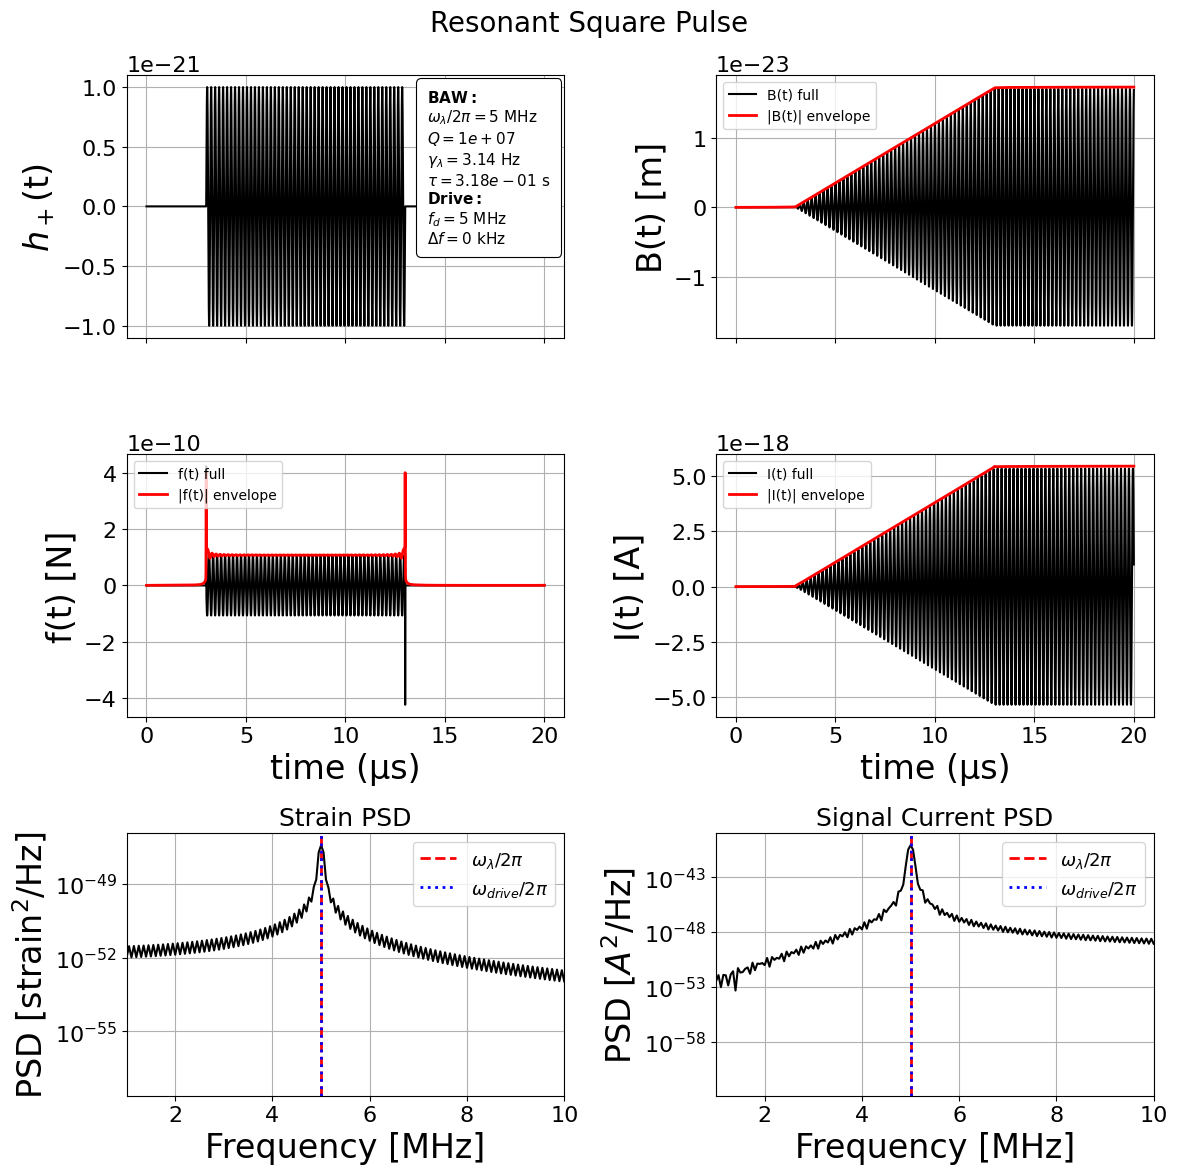

In [235]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = f0 * 1.   # Detuning

h0 = 1e-21


# Square pulse
t_start = 3e-6
t_end = 13e-6
sigma_t = 5e-7 # s
window = np.heaviside(t - t_start,1) * (1 - np.heaviside(t - t_end,1))#np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window * np.sin(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Resonant Square Pulse")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force_env_ref,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)



axs[2,0].plot(freq/1e6, Shh, color='k')
# ax_twin = axs[2,0].twinx()
# ax_twin.plot(freq/1e6, Sff, color='r', ls=':')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,10)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')

axs[2,1].set_yscale('log')
# axs[2,1].set_xlim(3,8)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/square_pulse_resonant.png')

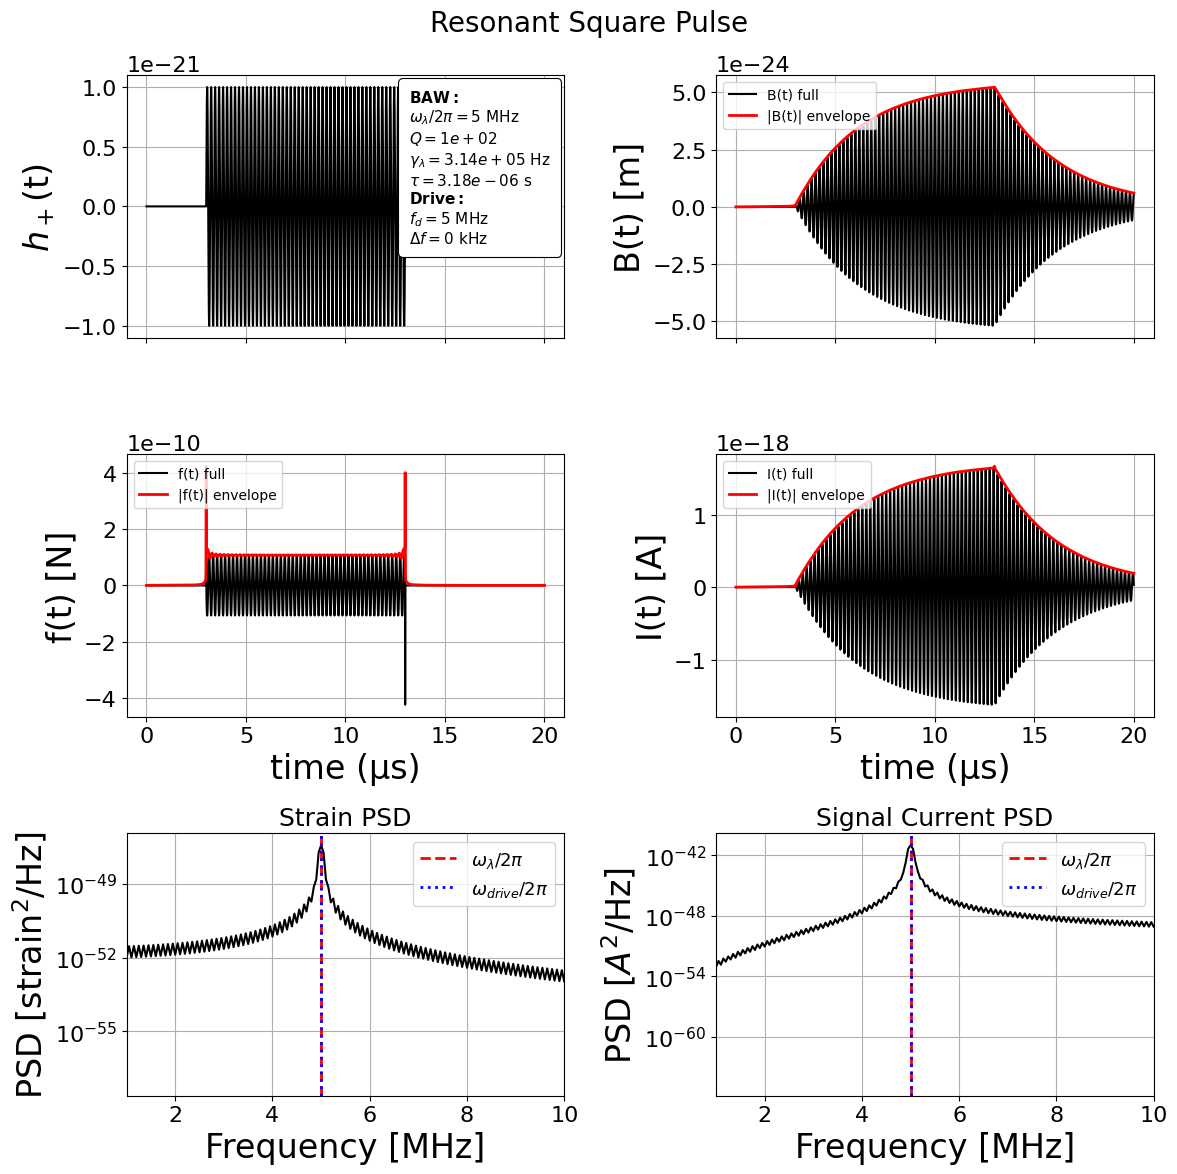

In [238]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e2,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = f0 * 1.   # Detuning

h0 = 1e-21


# Square pulse
t_start = 3e-6
t_end = 13e-6
sigma_t = 5e-7 # s
window = np.heaviside(t - t_start,1) * (1 - np.heaviside(t - t_end,1))#np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window * np.sin(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Resonant Square Pulse")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force_env_ref,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)



axs[2,0].plot(freq/1e6, Shh, color='k')
# ax_twin = axs[2,0].twinx()
# ax_twin.plot(freq/1e6, Sff, color='r', ls=':')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,10)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')

axs[2,1].set_yscale('log')
# axs[2,1].set_xlim(3,8)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/square_pulse_resonant_lowQ.png')

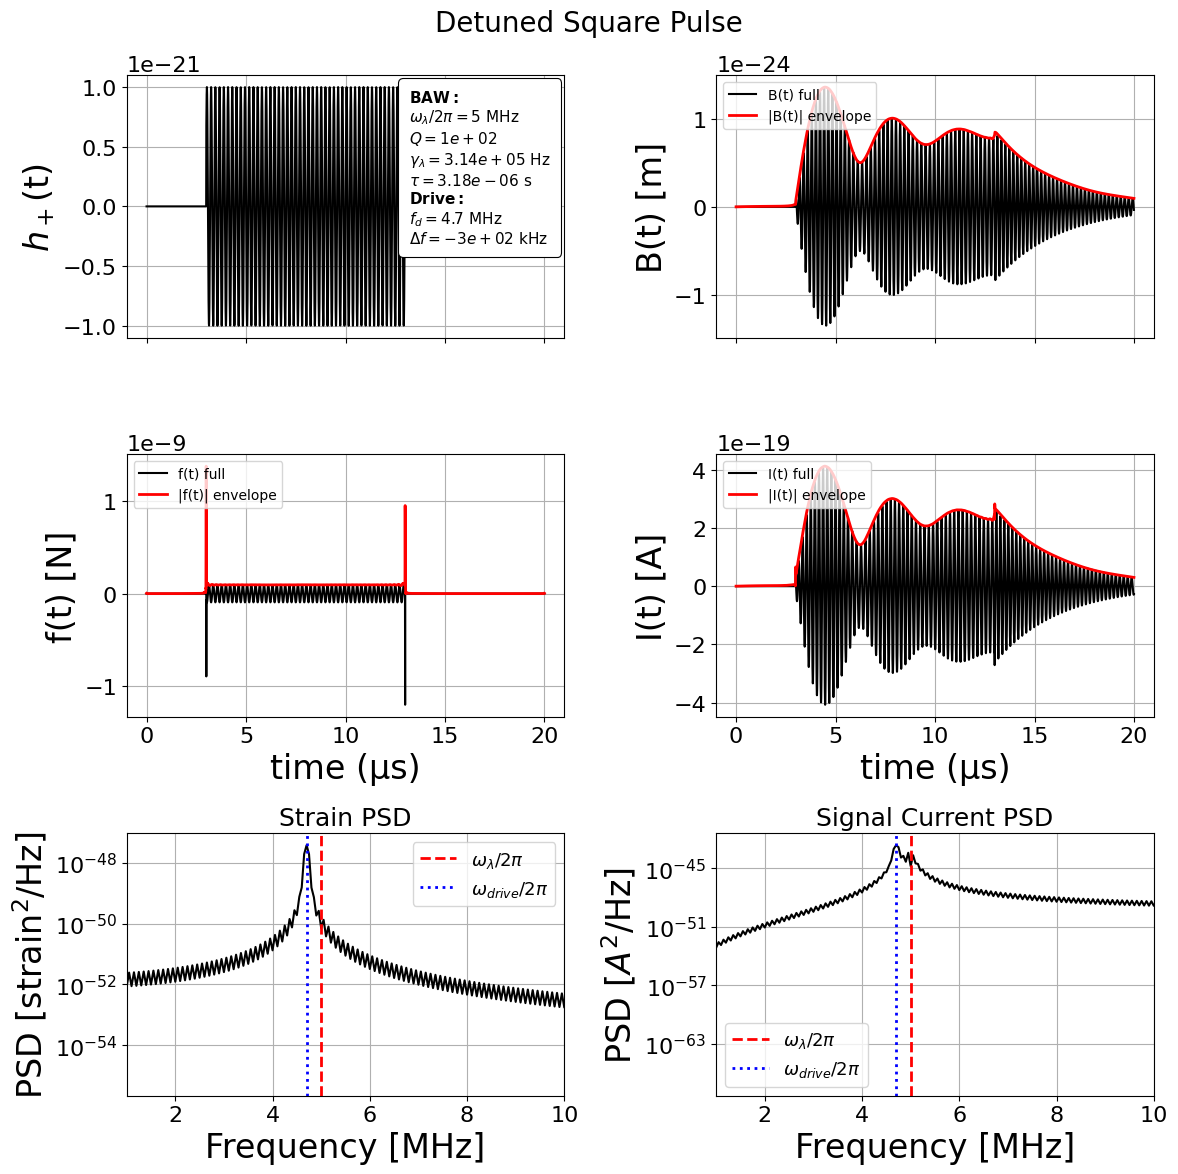

In [240]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e2,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = 4.7e6   # Detuning

h0 = 1e-21


# Square pulse
t_start = 3e-6
t_end = 13e-6
sigma_t = 5e-7 # s
window = np.heaviside(t - t_start,1) * (1 - np.heaviside(t - t_end,1))#np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window * np.sin(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Detuned Square Pulse")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force_env_ref,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)



axs[2,0].plot(freq/1e6, Shh, color='k')
# ax_twin = axs[2,0].twinx()
# ax_twin.plot(freq/1e6, Sff, color='r', ls=':')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,10)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')

axs[2,1].set_yscale('log')
# axs[2,1].set_xlim(3,8)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/square_pulse_detuned_lowQ.png')

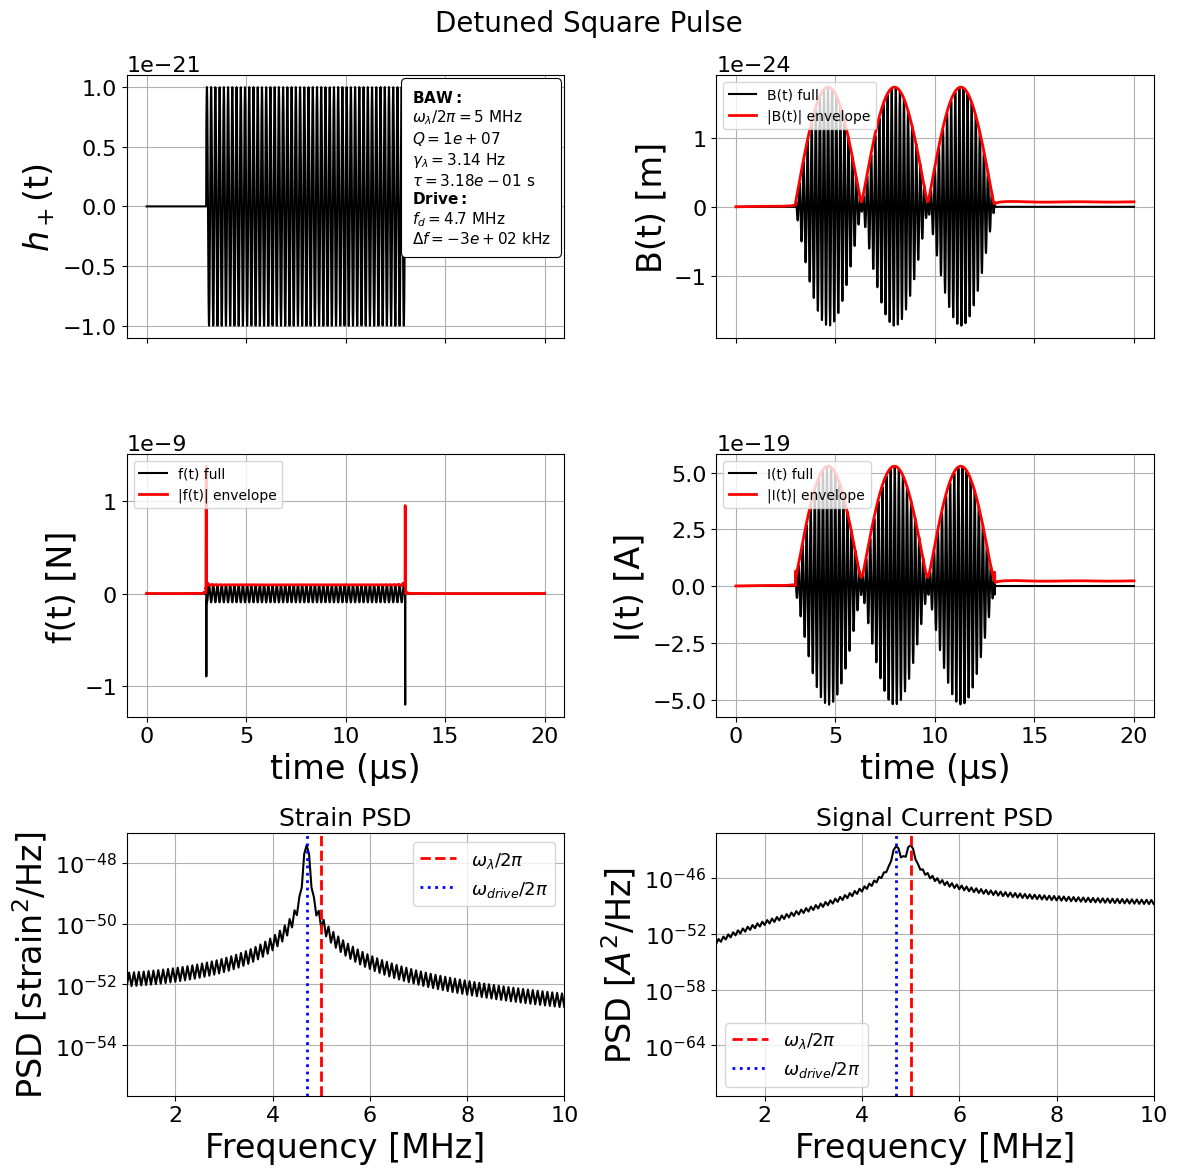

In [236]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = 4.7e6  # Detuning

h0 = 1e-21


# Square pulse
t_start = 3e-6
t_end = 13e-6
sigma_t = 5e-7 # s
window = np.heaviside(t - t_start,1) * (1 - np.heaviside(t - t_end,1))#np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window * np.sin(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Detuned Square Pulse")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force_env_ref,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)



axs[2,0].plot(freq/1e6, Shh, color='k')
# ax_twin = axs[2,0].twinx()
# ax_twin.plot(freq/1e6, Sff, color='r', ls=':')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,10)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')

axs[2,1].set_yscale('log')
# axs[2,1].set_xlim(3,8)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/square_pulse_detuned.png')

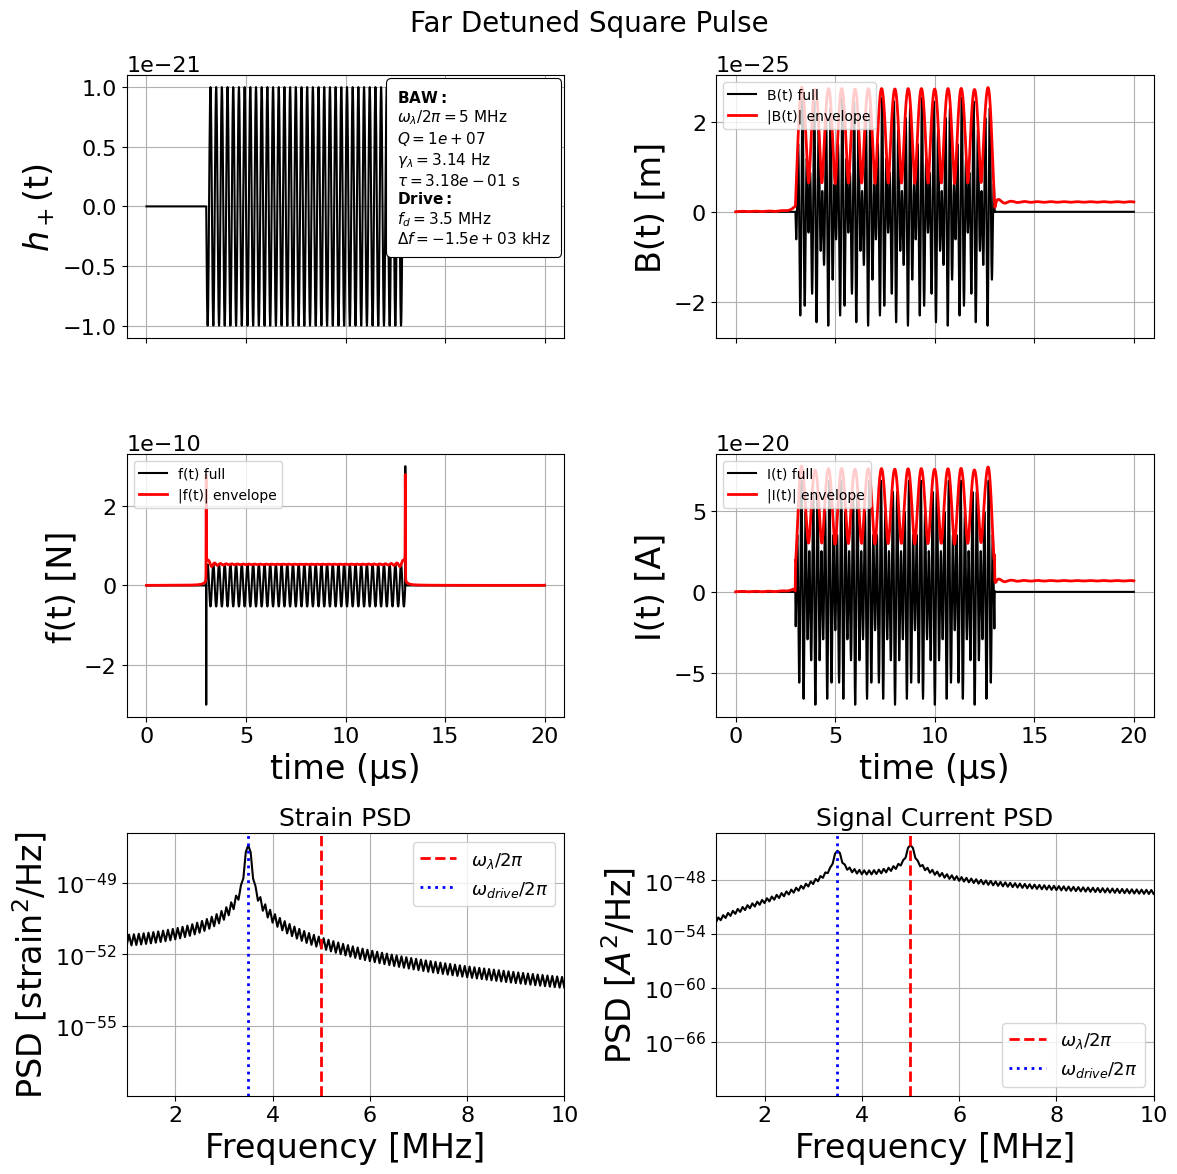

In [237]:
# Define the time grid
fs = 250e6              # sampling rate (Hz)
T  = 20e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = 3.5e6  # Detuning

h0 = 1e-21


# Square pulse
t_start = 3e-6
t_end = 13e-6
sigma_t = 5e-7 # s
window = np.heaviside(t - t_start,1) * (1 - np.heaviside(t - t_end,1))#np.exp(-0.5*(t-t_center)**2/(sigma_t**2))
h_plus = h0 * window * np.sin(2*np.pi*f_drive*t)

# Full solution for the displacement and current with Green's function
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.suptitle("Far Detuned Square Pulse")

# Share x only among the first two rows (4 axes)
axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

# # Optionally also link left/right within the same row
# axs[0,0].sharex(axs[0,1])
# axs[1,0].sharex(axs[1,1])

# Hide x tick labels where appropriate
for ax in axs[0, :]:
    ax.tick_params(labelbottom=False)

axs[0,0].plot(t*1e6, h_plus, color='k')
axs[0,0].set_ylabel("$h_+$(t)")

axs[1,0].plot(t*1e6, f_force, label="f(t) full", color='k')
axs[1,0].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1,0].set_ylabel("f(t) [N]")
axs[1,0].legend(loc="upper left")
axs[1,0].set_xlabel("time (µs)")

axs[0,1].plot(t*1e6, B, label="B(t) full", color='k')
axs[0,1].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[0,1].set_ylabel("B(t) [m]")
axs[0,1].legend(loc="upper left")


axs[1,1].plot(t*1e6, I, label="I(t) full", color='k')
axs[1,1].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[1,1].set_ylabel("I(t) [A]")
axs[1,1].set_xlabel("time (µs)")
axs[1,1].legend(loc="upper left")

add_baw_info_box(axs[0,0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)


freq, Sxx = welch(
    I,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Shh = welch(
    h_plus,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)

freq, Sff = welch(
    f_force_env_ref,
    fs=fs,
    window="hann",
    nperseg=len(t),      # larger → better freq resolution, less smoothing
    noverlap=len(t)//2,     # typical: 50%
    scaling="density"  # gives A^2/Hz
)



axs[2,0].plot(freq/1e6, Shh, color='k')
# ax_twin = axs[2,0].twinx()
# ax_twin.plot(freq/1e6, Sff, color='r', ls=':')
axs[2,0].set_ylabel(r"PSD [strain$^2$/Hz]")
axs[2,0].set_title("Strain PSD") 
axs[2,0].set_xlabel('Frequency [MHz]')
# axs[2,0].set_xscale('log')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim(1,10)
axs[2,0].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,0].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')
axs[2,0].legend(fontsize=13)

axs[2,1].plot(freq/1e6, Sxx, color='k')
axs[2,1].set_ylabel(r"PSD [$A^2$/Hz]")  # if I truly in A
axs[2,1].set_xlabel('Frequency [MHz]')
# axs[2,1].set_xscale('log')
axs[2,1].set_xlim(1,10)
axs[2,1].axvline(baw.omega_lambda/2/np.pi/1e6, color='r', ls='--', lw=2, label=r'$\omega_\lambda/2\pi$')
axs[2,1].axvline(f_drive/1e6, color='b', ls=':', lw=2, label=r'$\omega_{drive}/2\pi$')

axs[2,1].set_yscale('log')
# axs[2,1].set_xlim(3,8)
axs[2,1].set_title('Signal Current PSD')
axs[2,1].legend(fontsize=13)

for ax in axs:
    for a in ax:
        a.grid()

fig.tight_layout()
fig.savefig('plots/BAW/square_pulse_far_detuned.png')

# Envelope frequency sweep

Elapsed time: 83.843795 s

Elapsed time: 0.533296 



C:\Users\olin_\AppData\Local\Temp\ipykernel_20384\2011415669.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\olin_\AppData\Local\Temp\ipykernel_20384\2011415669.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


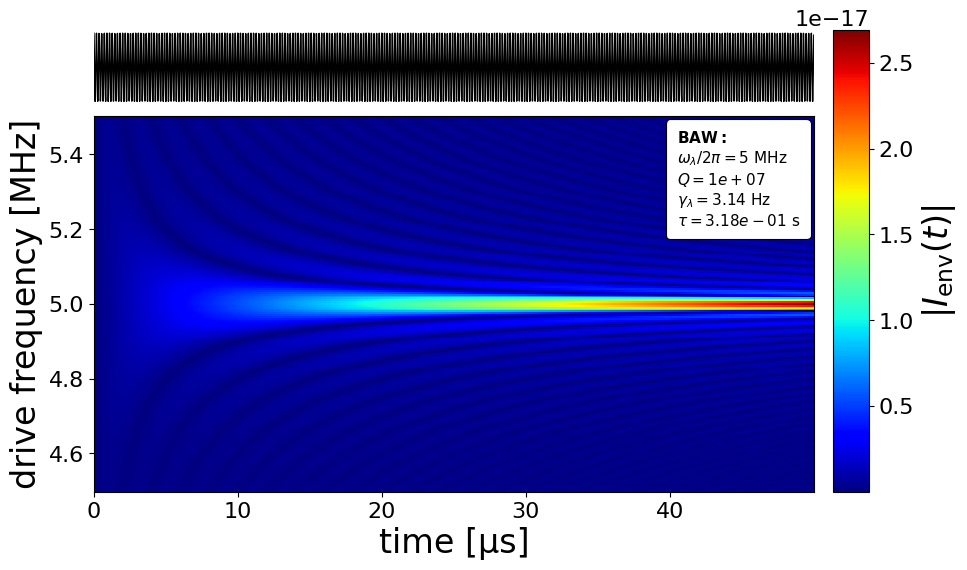

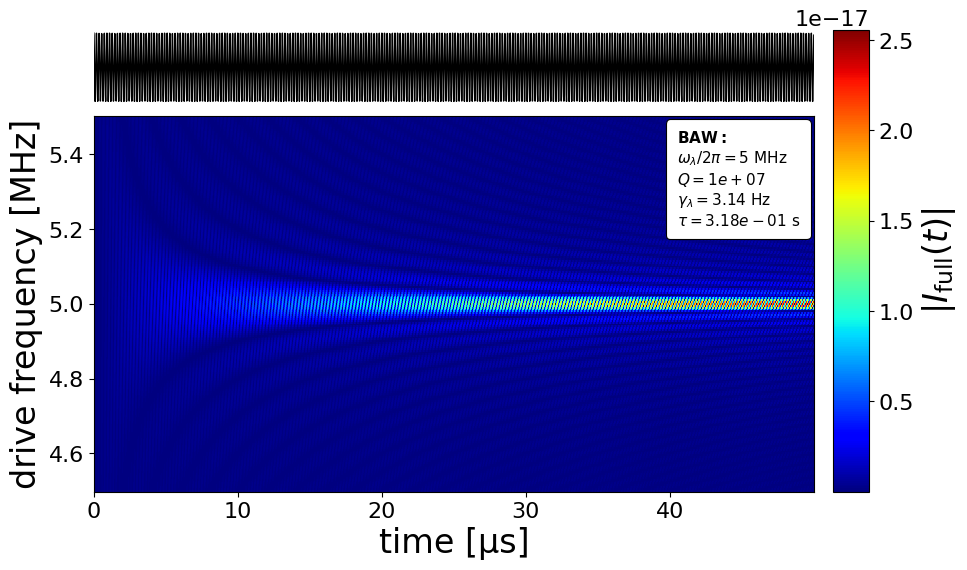

In [5]:
# -----------------------------
# Frequency sweep around omega0
# -----------------------------
h0 = 1e-21
fs = 100e6              # sampling rate (Hz)
T  = 5e-5             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]
window = np.ones_like(t)# np.exp(-(t-t_on)**2/(5e-7**2))
# -----------------------------
# Example BAW mode
# -----------------------------
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

f0 = baw.omega_lambda / (2*np.pi)

Nf = 201
f_list = np.linspace(f0-5e5, f0+5e5, Nf)

I_full_map = np.zeros((Nf, len(t)))
I_env_map  = np.zeros((Nf, len(t)))



print(f'{0/len(f_list)*100:.2f} %', end='\r')

t0 = time.perf_counter()
for i, f_drive in enumerate(f_list):
    print(f'{(i+1)/len(f_list)*100:.2f} %', end='\r')
    h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)

    B, Bdot, I, f_force = baw.solve_current(
        t,
        h_plus,
        use_green=True,
    )

    I_full_map[i, :] = np.abs(I)
dt = time.perf_counter() - t0
print(f"Elapsed time: {dt:.6f} s\n")

print(f'{0/len(f_list)*100:.2f} %', end='\r')

t0 = time.perf_counter()
for i, f_drive in enumerate(f_list):
    
    h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)
    omega_d_of_t = 2*np.pi * f_drive * np.ones_like(t)

    A_t, V_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
        t=t,
        h_plus=h_plus,
        omega_d_of_t=omega_d_of_t,
        omega_c=baw.omega_lambda,
        use_hilbert=True,
    )
    print(f'{(i+1)/len(f_list)*100:.2f} %', end='\r')

    # reconstruct physical current magnitude
    I_env_map[i, :] =  np.abs(I_env)
dt = time.perf_counter() - t0
print(f"Elapsed time: {dt:.6f} \n")

fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[20, 1],
                      hspace=0.05, wspace=0.05)

# --- main colormesh FIRST (it will "own" the x ticks) ---
ax = fig.add_subplot(gs[1, 0])

pcm = ax.pcolormesh(
    t * 1e6,
    f_list * 1e-6,
    np.abs(I_env_map),
    shading="auto",
    cmap="jet",
)

ax.set_xlabel("time [µs]")
ax.set_ylabel("drive frequency [MHz]")
ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# --- top reference axis, share x with bottom ---
ax_top = fig.add_subplot(gs[0, 0], sharex=ax)
ax_top.plot(t * 1e6, h_plus, color="k", lw=1)

# hide everything on the top axis (keep only the curve)
ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax_top.set_yticks([])
for spine in ax_top.spines.values():
    spine.set_visible(False)

# --- colorbar in its own column (aligned widths) ---
cax = fig.add_subplot(gs[:, 1])
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label(r"$|I_{\mathrm{env}}(t)|$")

# ax.set_title("BAW current from envelope solver")

add_baw_info_box(ax, baw, show_Q=True, show_gamma_lambda=True, show_drive=False, sep = "\n", alpha=1, fontsize=11)

fig.tight_layout()
fig.savefig('plots/BAW/sweep_sine_wave.png')

fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[20, 1],
                      hspace=0.05, wspace=0.05)

# --- main colormesh FIRST (it will "own" the x ticks) ---
ax = fig.add_subplot(gs[1, 0])

pcm = ax.pcolormesh(
    t * 1e6,
    f_list * 1e-6,
    np.abs(I_full_map),
    shading="auto",
    cmap="jet",
)

ax.set_xlabel("time [µs]")
ax.set_ylabel("drive frequency [MHz]")
ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# --- top reference axis, share x with bottom ---
ax_top = fig.add_subplot(gs[0, 0], sharex=ax)
ax_top.plot(t * 1e6, h_plus, color="k", lw=1)

# hide everything on the top axis (keep only the curve)
ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax_top.set_yticks([])
for spine in ax_top.spines.values():
    spine.set_visible(False)

# --- colorbar in its own column (aligned widths) ---
cax = fig.add_subplot(gs[:, 1])
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label(r"$|I_{\mathrm{full}}(t)|$")

add_baw_info_box(ax, baw, show_Q=True, show_gamma_lambda=True, show_drive=False, sep = "\n", alpha=1, fontsize=11)

fig.tight_layout()
fig.savefig('plots/BAW/sweep_sine_wave_full.png')


Elapsed time: 82.875397 s

Elapsed time: 0.498602 



C:\Users\olin_\AppData\Local\Temp\ipykernel_20384\1381439536.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\olin_\AppData\Local\Temp\ipykernel_20384\1381439536.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


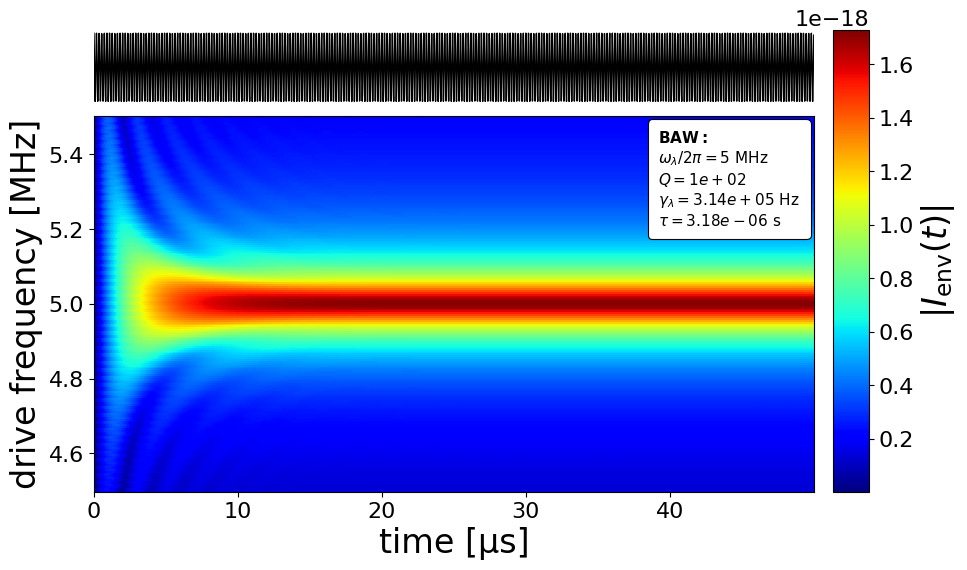

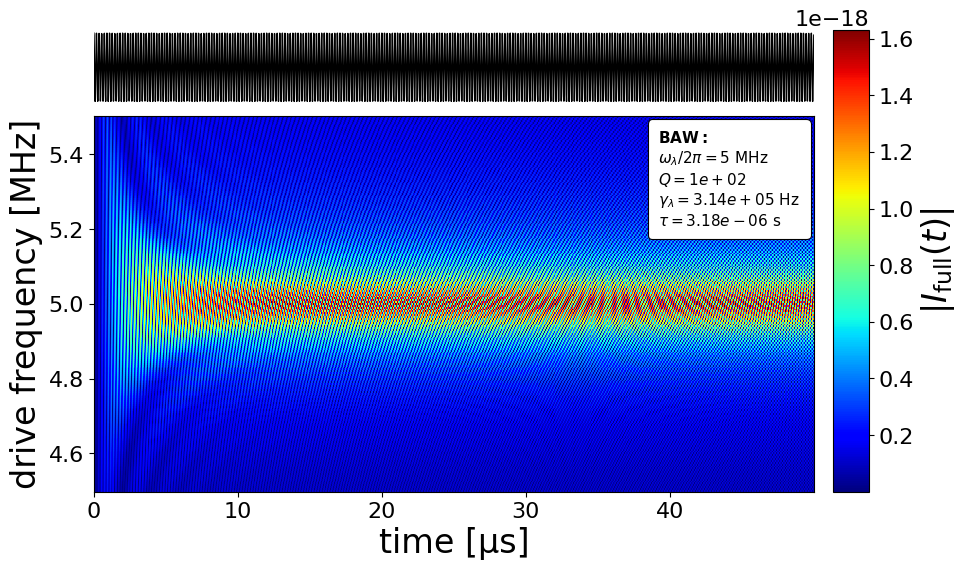

In [7]:
# -----------------------------
# Frequency sweep around omega0
# -----------------------------
h0 = 1e-21

fs = 100e6              # sampling rate (Hz)
T  = 5e-5             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]
window = np.ones_like(t)# np.exp(-(t-t_on)**2/(5e-7**2))
# -----------------------------
# Example BAW mode
# -----------------------------
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e2,
    k_lambda=1e-2,
)

f0 = baw.omega_lambda / (2*np.pi)

Nf = 201
f_list = np.linspace(f0-5e5, f0+5e5, Nf)

I_full_map = np.zeros((Nf, len(t)))
I_env_map  = np.zeros((Nf, len(t)))


print(f'{0/len(f_list)*100:.2f} %', end='\r')

t0 = time.perf_counter()
for i, f_drive in enumerate(f_list):
    print(f'{(i+1)/len(f_list)*100:.2f} %', end='\r')
    h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)

    B, Bdot, I, f_force = baw.solve_current(
        t,
        h_plus,
        use_green=True,
    )

    I_full_map[i, :] = np.abs(I)
dt = time.perf_counter() - t0
print(f"Elapsed time: {dt:.6f} s\n")

print(f'{0/len(f_list)*100:.2f} %', end='\r')

t0 = time.perf_counter()
for i, f_drive in enumerate(f_list):
    
    h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)
    omega_d_of_t = 2*np.pi * f_drive * np.ones_like(t)

    A_t, V_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
        t=t,
        h_plus=h_plus,
        omega_d_of_t=omega_d_of_t,
        omega_c=baw.omega_lambda,
        use_hilbert=True,
    )
    print(f'{(i+1)/len(f_list)*100:.2f} %', end='\r')

    # reconstruct physical current magnitude
    I_env_map[i, :] =  np.abs(I_env)
dt = time.perf_counter() - t0
print(f"Elapsed time: {dt:.6f} \n")

fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[20, 1],
                      hspace=0.05, wspace=0.05)

# --- main colormesh FIRST (it will "own" the x ticks) ---
ax = fig.add_subplot(gs[1, 0])

pcm = ax.pcolormesh(
    t * 1e6,
    f_list * 1e-6,
    np.abs(I_env_map),
    shading="auto",
    cmap="jet",
)

ax.set_xlabel("time [µs]")
ax.set_ylabel("drive frequency [MHz]")
ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# --- top reference axis, share x with bottom ---
ax_top = fig.add_subplot(gs[0, 0], sharex=ax)
ax_top.plot(t * 1e6, h_plus, color="k", lw=1)

# hide everything on the top axis (keep only the curve)
ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax_top.set_yticks([])
for spine in ax_top.spines.values():
    spine.set_visible(False)

# --- colorbar in its own column (aligned widths) ---
cax = fig.add_subplot(gs[:, 1])
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label(r"$|I_{\mathrm{env}}(t)|$")

# ax.set_title("BAW current from envelope solver")

add_baw_info_box(ax, baw, show_Q=True, show_gamma_lambda=True, show_drive=False, sep = "\n", alpha=1, fontsize=11)

fig.tight_layout()
fig.savefig('plots/BAW/sweep_sine_wave_lowQ.png')

fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[20, 1],
                      hspace=0.05, wspace=0.05)

# --- main colormesh FIRST (it will "own" the x ticks) ---
ax = fig.add_subplot(gs[1, 0])

pcm = ax.pcolormesh(
    t * 1e6,
    f_list * 1e-6,
    np.abs(I_full_map),
    shading="auto",
    cmap="jet",
)

ax.set_xlabel("time [µs]")
ax.set_ylabel("drive frequency [MHz]")
ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# --- top reference axis, share x with bottom ---
ax_top = fig.add_subplot(gs[0, 0], sharex=ax)
ax_top.plot(t * 1e6, h_plus, color="k", lw=1)

# hide everything on the top axis (keep only the curve)
ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax_top.set_yticks([])
for spine in ax_top.spines.values():
    spine.set_visible(False)

# --- colorbar in its own column (aligned widths) ---
cax = fig.add_subplot(gs[:, 1])
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label(r"$|I_{\mathrm{full}}(t)|$")

add_baw_info_box(ax, baw, show_Q=True, show_gamma_lambda=True, show_drive=False, sep = "\n", alpha=1, fontsize=11)

fig.tight_layout()
fig.savefig('plots/BAW/sweep_sine_wave_full_lowQ.png')


Elapsed time: 85.461650 s

Elapsed time: 0.497175 



C:\Users\olin_\AppData\Local\Temp\ipykernel_20384\2099234471.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\olin_\AppData\Local\Temp\ipykernel_20384\2099234471.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


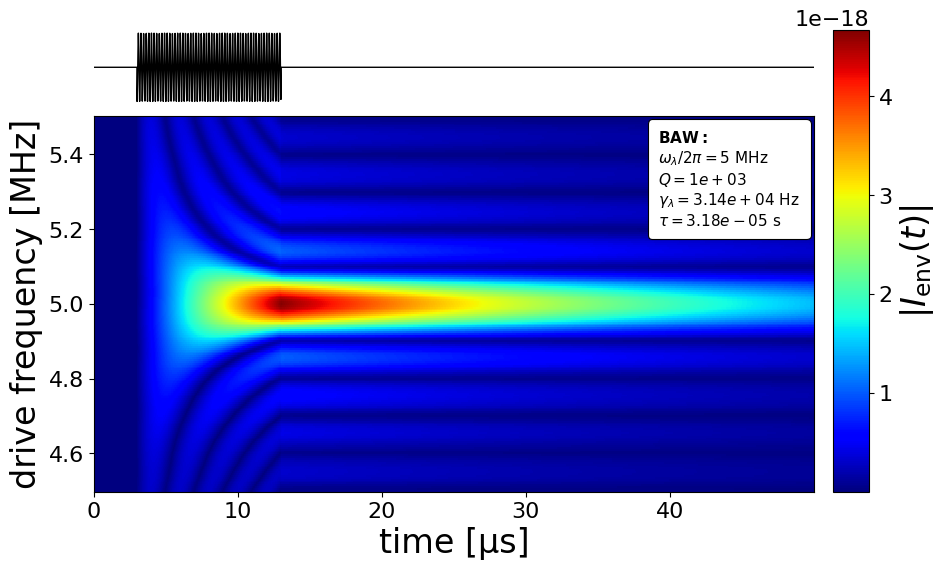

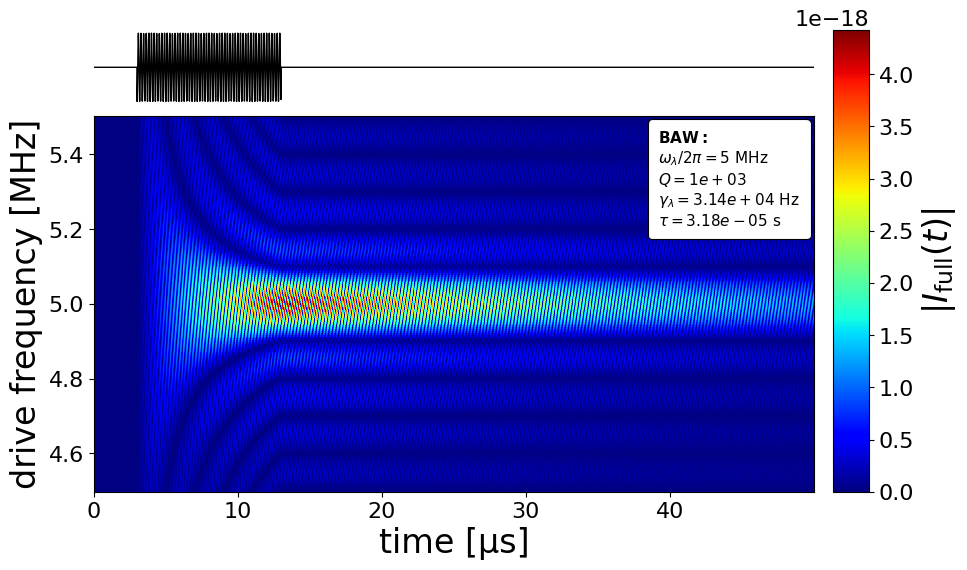

In [8]:
# -----------------------------
# Frequency sweep around omega0
# -----------------------------
h0 = 1e-21

fs = 100e6              # sampling rate (Hz)
T  = 5e-5             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]
# Square pulse
t_start = 3e-6
t_end = 13e-6
sigma_t = 5e-7 # s
window = np.heaviside(t - t_start,1) * (1 - np.heaviside(t - t_end,1))
# np.exp(-(t-t_on)**2/(5e-7**2))
# -----------------------------
# Example BAW mode
# -----------------------------
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e3,
    k_lambda=1e-2,
)

f0 = baw.omega_lambda / (2*np.pi)

Nf = 201
f_list = np.linspace(f0-5e5, f0+5e5, Nf)

I_full_map = np.zeros((Nf, len(t)))
I_env_map  = np.zeros((Nf, len(t)))


print(f'{0/len(f_list)*100:.2f} %', end='\r')

t0 = time.perf_counter()
for i, f_drive in enumerate(f_list):
    print(f'{(i+1)/len(f_list)*100:.2f} %', end='\r')
    h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)

    B, Bdot, I, f_force = baw.solve_current(
        t,
        h_plus,
        use_green=True,
    )

    I_full_map[i, :] = np.abs(I)
dt = time.perf_counter() - t0
print(f"Elapsed time: {dt:.6f} s\n")

print(f'{0/len(f_list)*100:.2f} %', end='\r')

t0 = time.perf_counter()
for i, f_drive in enumerate(f_list):
    
    h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)
    omega_d_of_t = 2*np.pi * f_drive * np.ones_like(t)

    A_t, V_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
        t=t,
        h_plus=h_plus,
        omega_d_of_t=omega_d_of_t,
        omega_c=baw.omega_lambda,
        use_hilbert=True,
    )
    print(f'{(i+1)/len(f_list)*100:.2f} %', end='\r')

    # reconstruct physical current magnitude
    I_env_map[i, :] =  np.abs(I_env)
dt = time.perf_counter() - t0
print(f"Elapsed time: {dt:.6f} \n")


fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[20, 1],
                      hspace=0.05, wspace=0.05)

# --- main colormesh FIRST (it will "own" the x ticks) ---
ax = fig.add_subplot(gs[1, 0])

pcm = ax.pcolormesh(
    t * 1e6,
    f_list * 1e-6,
    np.abs(I_env_map),
    shading="auto",
    cmap="jet",
)

ax.set_xlabel("time [µs]")
ax.set_ylabel("drive frequency [MHz]")
ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# --- top reference axis, share x with bottom ---
ax_top = fig.add_subplot(gs[0, 0], sharex=ax)
ax_top.plot(t * 1e6, h_plus, color="k", lw=1)

# hide everything on the top axis (keep only the curve)
ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax_top.set_yticks([])
for spine in ax_top.spines.values():
    spine.set_visible(False)

# --- colorbar in its own column (aligned widths) ---
cax = fig.add_subplot(gs[:, 1])
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label(r"$|I_{\mathrm{env}}(t)|$")

# ax.set_title("BAW current from envelope solver")

add_baw_info_box(ax, baw, show_Q=True, show_gamma_lambda=True, show_drive=False, sep = "\n", alpha=1, fontsize=11)

fig.tight_layout()
fig.savefig('plots/BAW/sweep_square_pulse_lowQ.png')

fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[20, 1],
                      hspace=0.05, wspace=0.05)

# --- main colormesh FIRST (it will "own" the x ticks) ---
ax = fig.add_subplot(gs[1, 0])

pcm = ax.pcolormesh(
    t * 1e6,
    f_list * 1e-6,
    np.abs(I_full_map),
    shading="auto",
    cmap="jet",
)

ax.set_xlabel("time [µs]")
ax.set_ylabel("drive frequency [MHz]")
ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# --- top reference axis, share x with bottom ---
ax_top = fig.add_subplot(gs[0, 0], sharex=ax)
ax_top.plot(t * 1e6, h_plus, color="k", lw=1)

# hide everything on the top axis (keep only the curve)
ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax_top.set_yticks([])
for spine in ax_top.spines.values():
    spine.set_visible(False)

# --- colorbar in its own column (aligned widths) ---
cax = fig.add_subplot(gs[:, 1])
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label(r"$|I_{\mathrm{full}}(t)|$")

add_baw_info_box(ax, baw, show_Q=True, show_gamma_lambda=True, show_drive=False, sep = "\n", alpha=1, fontsize=11)

fig.tight_layout()
fig.savefig('plots/BAW/sweep_square_pulse_full_lowQ.png')

Elapsed time: 86.784286 s

Elapsed time: 0.496438 



C:\Users\olin_\AppData\Local\Temp\ipykernel_20384\4265297994.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\olin_\AppData\Local\Temp\ipykernel_20384\4265297994.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


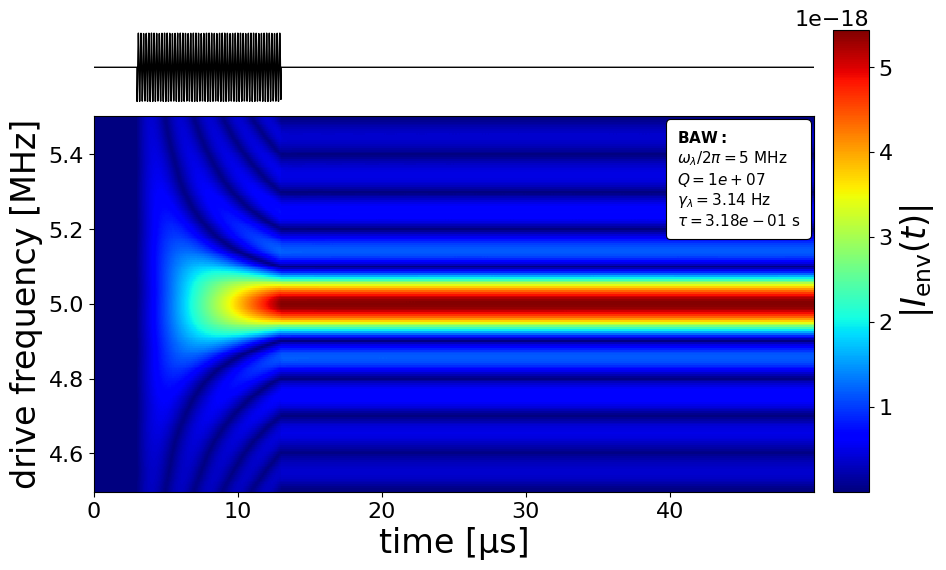

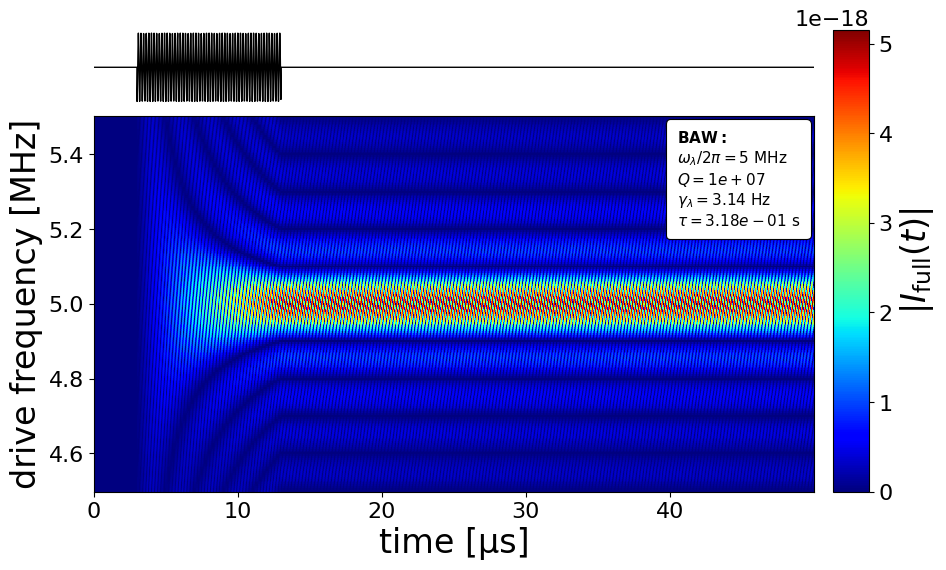

In [9]:
# -----------------------------
# Frequency sweep around omega0
# -----------------------------
fs = 100e6              # sampling rate (Hz)
T  = 5e-5             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]
h0=1e-21
# Square pulse
t_start = 3e-6
t_end = 13e-6
sigma_t = 5e-7 # s
window = np.heaviside(t - t_start,1) * (1 - np.heaviside(t - t_end,1))
# np.exp(-(t-t_on)**2/(5e-7**2))
# -----------------------------
# Example BAW mode
# -----------------------------
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

f0 = baw.omega_lambda / (2*np.pi)

Nf = 201
f_list = np.linspace(f0-5e5, f0+5e5, Nf)

I_full_map = np.zeros((Nf, len(t)))
I_env_map  = np.zeros((Nf, len(t)))


print(f'{0/len(f_list)*100:.2f} %', end='\r')

t0 = time.perf_counter()
for i, f_drive in enumerate(f_list):
    print(f'{(i+1)/len(f_list)*100:.2f} %', end='\r')
    h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)

    B, Bdot, I, f_force = baw.solve_current(
        t,
        h_plus,
        use_green=True,
    )

    I_full_map[i, :] = np.abs(I)
dt = time.perf_counter() - t0
print(f"Elapsed time: {dt:.6f} s\n")

print(f'{0/len(f_list)*100:.2f} %', end='\r')

t0 = time.perf_counter()
for i, f_drive in enumerate(f_list):
    
    h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)
    omega_d_of_t = 2*np.pi * f_drive * np.ones_like(t)

    A_t, V_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
        t=t,
        h_plus=h_plus,
        omega_d_of_t=omega_d_of_t,
        omega_c=baw.omega_lambda,
        use_hilbert=True,
    )
    print(f'{(i+1)/len(f_list)*100:.2f} %', end='\r')

    # reconstruct physical current magnitude
    I_env_map[i, :] =  np.abs(I_env)
dt = time.perf_counter() - t0
print(f"Elapsed time: {dt:.6f} \n")

fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[20, 1],
                      hspace=0.05, wspace=0.05)

# --- main colormesh FIRST (it will "own" the x ticks) ---
ax = fig.add_subplot(gs[1, 0])

pcm = ax.pcolormesh(
    t * 1e6,
    f_list * 1e-6,
    np.abs(I_env_map),
    shading="auto",
    cmap="jet",
)

ax.set_xlabel("time [µs]")
ax.set_ylabel("drive frequency [MHz]")
ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# --- top reference axis, share x with bottom ---
ax_top = fig.add_subplot(gs[0, 0], sharex=ax)
ax_top.plot(t * 1e6, h_plus, color="k", lw=1)

# hide everything on the top axis (keep only the curve)
ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax_top.set_yticks([])
for spine in ax_top.spines.values():
    spine.set_visible(False)

# --- colorbar in its own column (aligned widths) ---
cax = fig.add_subplot(gs[:, 1])
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label(r"$|I_{\mathrm{env}}(t)|$")

# ax.set_title("BAW current from envelope solver")

add_baw_info_box(ax, baw, show_Q=True, show_gamma_lambda=True, show_drive=False, sep = "\n", alpha=1, fontsize=11)

fig.tight_layout()
fig.savefig('plots/BAW/sweep_square_pulse.png')


fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[20, 1],
                      hspace=0.05, wspace=0.05)

# --- main colormesh FIRST (it will "own" the x ticks) ---
ax = fig.add_subplot(gs[1, 0])

pcm = ax.pcolormesh(
    t * 1e6,
    f_list * 1e-6,
    np.abs(I_full_map),
    shading="auto",
    cmap="jet",
)

ax.set_xlabel("time [µs]")
ax.set_ylabel("drive frequency [MHz]")
ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# --- top reference axis, share x with bottom ---
ax_top = fig.add_subplot(gs[0, 0], sharex=ax)
ax_top.plot(t * 1e6, h_plus, color="k", lw=1)

# hide everything on the top axis (keep only the curve)
ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax_top.set_yticks([])
for spine in ax_top.spines.values():
    spine.set_visible(False)

# --- colorbar in its own column (aligned widths) ---
cax = fig.add_subplot(gs[:, 1])
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label(r"$|I_{\mathrm{full}}(t)|$")

add_baw_info_box(ax, baw, show_Q=True, show_gamma_lambda=True, show_drive=False, sep = "\n", alpha=1, fontsize=11)

fig.tight_layout()
fig.savefig('plots/BAW/sweep_square_pulse_full.png')

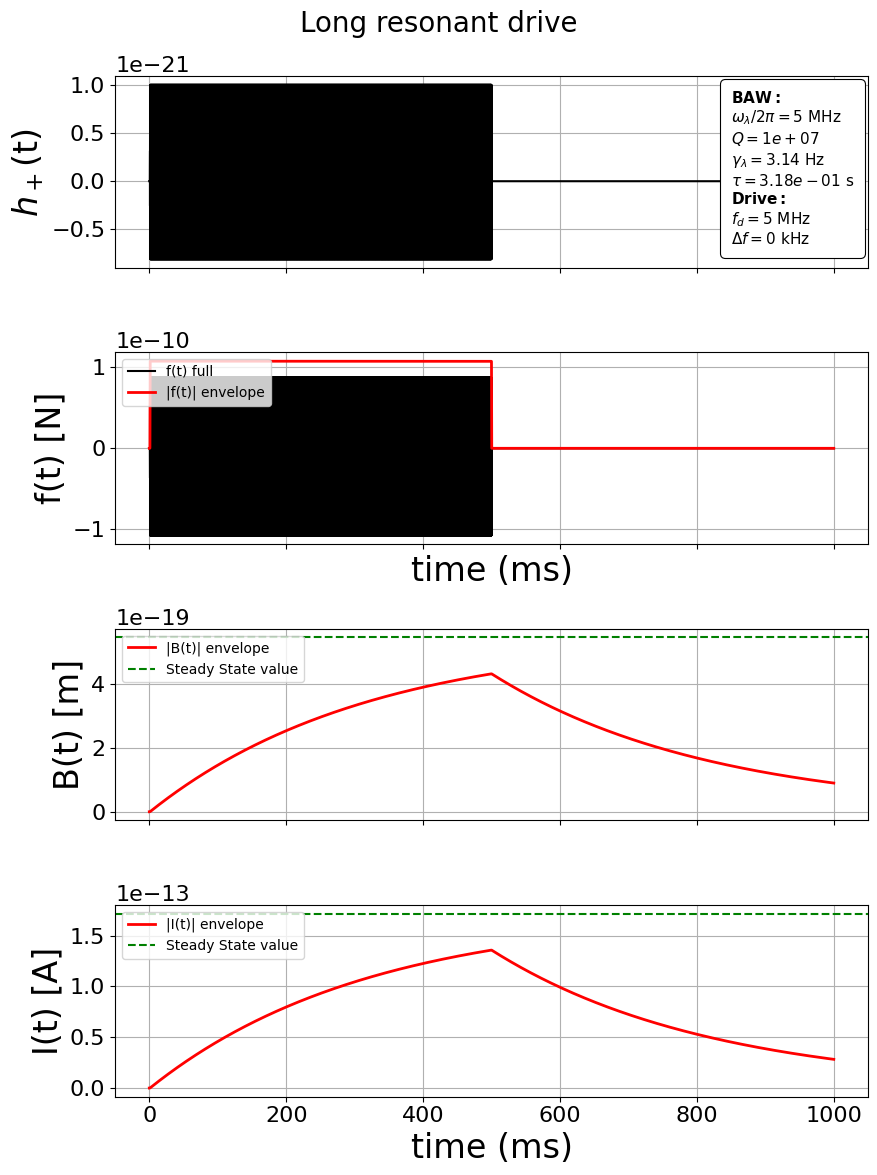

In [47]:
# Define the time grid
fs = 25e6              # sampling rate (Hz)
T  = 1000e-3             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = f0 * 1.0   # Detuning

h0 = 1e-21


# Square
t_start = 1e-3
t_end = 500e-3
sigma_t = 50e-6 # s
window = 0.5 * (1 + np.tanh((t - t_start)/sigma_t)) * (1- 0.5 * (1 + np.tanh((t - t_end)/sigma_t)))

h_plus = h0 * window * np.cos(2*np.pi*f0*t)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(4,1, figsize=(9, 12), sharex=True)
fig.suptitle("Long resonant drive")

axs[0].plot(t*1e3, h_plus, color='k')
axs[0].set_ylabel("$h_+$(t)")

axs[1].plot(t*1e3, f_force_env_ref, label="f(t) full", color='k')
axs[1].plot(t*1e3, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1].set_ylabel("f(t) [N]")
axs[1].legend(loc="upper left")
axs[1].set_xlabel("time (ms)")

# axs[2].plot(t*1e3, B, label="B(t) full", color='k')
axs[2].plot(t*1e3, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[2].set_ylabel("B(t) [m]")
axs[2].axhline(np.max(np.abs(F_env))/2/baw.omega_lambda/baw.gamma_lambda, ls='--', color='green', label='Steady State value')
axs[2].legend(loc="upper left")


# axs[3].plot(t*1e3, I, label="I(t) full", color='k')
axs[3].plot(t*1e3, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[3].set_ylabel("I(t) [A]")
axs[3].set_xlabel("time (ms)")
axs[3].axhline(np.max(np.abs(F_env))/2/baw.omega_lambda/baw.gamma_lambda*baw.k_lambda*baw.omega_lambda, ls='--', color='green', label='Steady State value')
axs[3].legend(loc="upper left")

add_baw_info_box(axs[0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)

for ax in axs:
    ax.grid()
fig.tight_layout()
fig.savefig('plots/BAW/long_square_pulse_Q1e7.png')

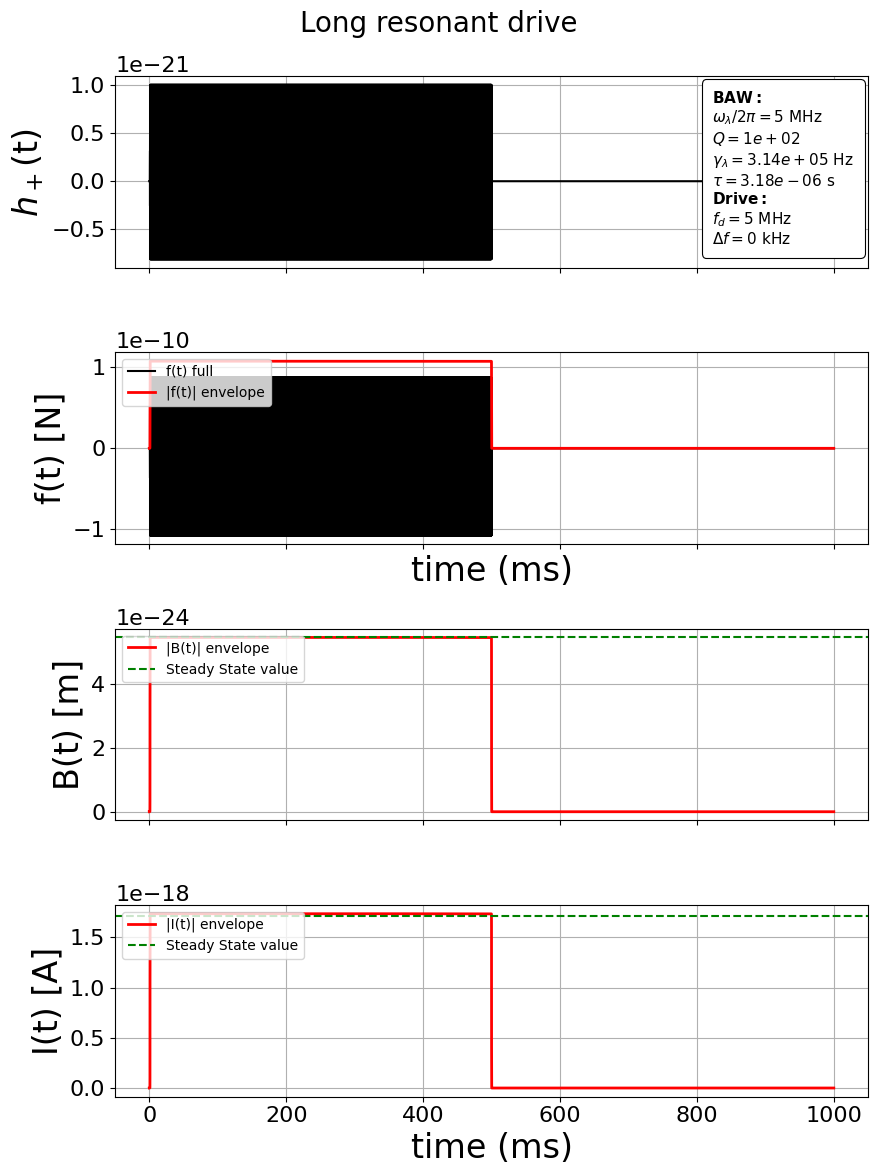

In [48]:
# Define the time grid
fs = 25e6              # sampling rate (Hz)
T  = 1000e-3             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e2,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = f0 * 1.0   # Detuning

h0 = 1e-21


# Square
t_start = 1e-3
t_end = 500e-3
sigma_t = 50e-6 # s
window = 0.5 * (1 + np.tanh((t - t_start)/sigma_t)) * (1- 0.5 * (1 + np.tanh((t - t_end)/sigma_t)))

h_plus = h0 * window * np.cos(2*np.pi*f0*t)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(4,1, figsize=(9, 12), sharex=True)
fig.suptitle("Long resonant drive")

axs[0].plot(t*1e3, h_plus, color='k')
axs[0].set_ylabel("$h_+$(t)")

axs[1].plot(t*1e3, f_force_env_ref, label="f(t) full", color='k')
axs[1].plot(t*1e3, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1].set_ylabel("f(t) [N]")
axs[1].legend(loc="upper left")
axs[1].set_xlabel("time (ms)")

# axs[2].plot(t*1e3, B, label="B(t) full", color='k')
axs[2].plot(t*1e3, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[2].set_ylabel("B(t) [m]")
axs[2].axhline(np.max(np.abs(F_env))/2/baw.omega_lambda/baw.gamma_lambda, ls='--', color='green', label='Steady State value')
axs[2].legend(loc="upper left")


# axs[3].plot(t*1e3, I, label="I(t) full", color='k')
axs[3].plot(t*1e3, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[3].set_ylabel("I(t) [A]")
axs[3].set_xlabel("time (ms)")
axs[3].axhline(np.max(np.abs(F_env))/2/baw.omega_lambda/baw.gamma_lambda*baw.k_lambda*baw.omega_lambda, ls='--', color='green', label='Steady State value')
axs[3].legend(loc="upper left")

add_baw_info_box(axs[0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)

for ax in axs:
    ax.grid()
fig.tight_layout()
fig.savefig('plots/BAW/long_square_pulse_Q1e2.png')

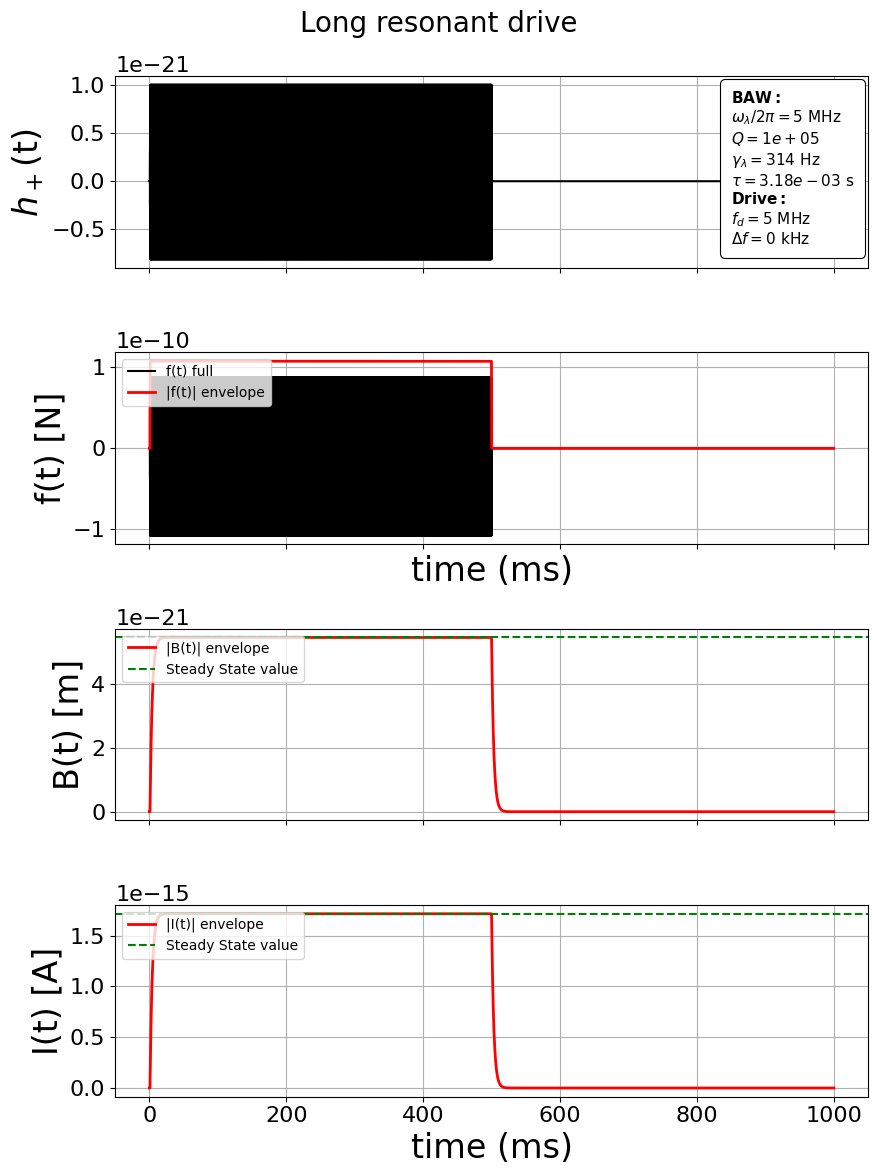

In [49]:
# Define the time grid
fs = 25e6              # sampling rate (Hz)
T  = 1000e-3             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e5,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = f0 * 1.0   # Detuning

h0 = 1e-21


# Square
t_start = 1e-3
t_end = 500e-3
sigma_t = 50e-6 # s
window = 0.5 * (1 + np.tanh((t - t_start)/sigma_t)) * (1- 0.5 * (1 + np.tanh((t - t_end)/sigma_t)))

h_plus = h0 * window * np.cos(2*np.pi*f0*t)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(4,1, figsize=(9, 12), sharex=True)
fig.suptitle("Long resonant drive")

axs[0].plot(t*1e3, h_plus, color='k')
axs[0].set_ylabel("$h_+$(t)")

axs[1].plot(t*1e3, f_force_env_ref, label="f(t) full", color='k')
axs[1].plot(t*1e3, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1].set_ylabel("f(t) [N]")
axs[1].legend(loc="upper left")
axs[1].set_xlabel("time (ms)")

# axs[2].plot(t*1e3, B, label="B(t) full", color='k')
axs[2].plot(t*1e3, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[2].set_ylabel("B(t) [m]")
axs[2].axhline(np.max(np.abs(F_env))/2/baw.omega_lambda/baw.gamma_lambda, ls='--', color='green', label='Steady State value')
axs[2].legend(loc="upper left")


# axs[3].plot(t*1e3, I, label="I(t) full", color='k')
axs[3].plot(t*1e3, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[3].set_ylabel("I(t) [A]")
axs[3].set_xlabel("time (ms)")
axs[3].axhline(np.max(np.abs(F_env))/2/baw.omega_lambda/baw.gamma_lambda*baw.k_lambda*baw.omega_lambda, ls='--', color='green', label='Steady State value')
axs[3].legend(loc="upper left")

add_baw_info_box(axs[0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)

for ax in axs:
    ax.grid()
fig.tight_layout()
fig.savefig('plots/BAW/long_square_pulse_Q1e5.png')

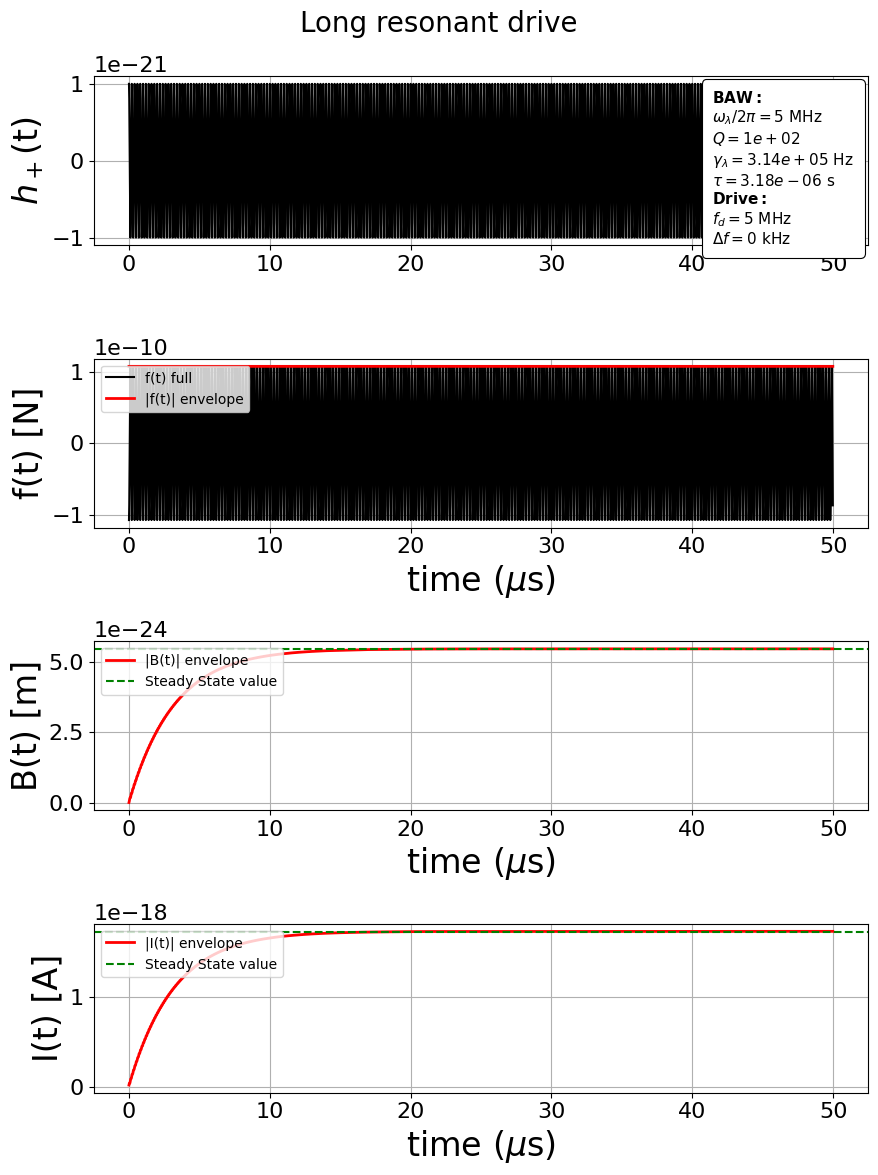

In [50]:
# Define the time grid
fs = 50e6              # sampling rate (Hz)
T  = 50e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# Define the mode parameters
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e2,
    k_lambda=1e-2,
)

# Define the strain force
f0 = baw.omega_lambda/(2*np.pi)
f_drive = f0 * 1.0   # Detuning

h0 = 1e-21


# Square
t_start = 1e-3
t_end = 500e-3
sigma_t = 50e-6 # s
window = np.ones_like(t)

h_plus = h0 * window * np.cos(2*np.pi*f0*t)

# Envelope solution (in the Rotating Frame) unsing Green's function
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=2*np.pi*f_drive,
    omega_c=None,
    use_hilbert=True,
)

fig, axs = plt.subplots(4,1, figsize=(9, 12), sharex=False)
fig.suptitle("Long resonant drive")

axs[0].plot(t*1e6, h_plus, color='k')
axs[0].set_ylabel("$h_+$(t)")

axs[1].plot(t*1e6, f_force_env_ref, label="f(t) full", color='k')
axs[1].plot(t*1e6, np.abs(F_env), label="|f(t)| envelope", color='r', lw=2)
axs[1].set_ylabel("f(t) [N]")
axs[1].legend(loc="upper left")
axs[1].set_xlabel(r"time ($\mu$s)")

# axs[2].plot(t*1e6, B, label="B(t) full", color='k')
axs[2].plot(t*1e6, np.abs(A_t), label="|B(t)| envelope", color='r', lw=2)
axs[2].set_ylabel("B(t) [m]")
axs[2].set_xlabel(r"time ($\mu$s)")
axs[2].axhline(np.max(np.abs(F_env))/2/baw.omega_lambda/baw.gamma_lambda, ls='--', color='green', label='Steady State value')
axs[2].legend(loc="upper left")

# axs[3].plot(t*1e6, I, label="I(t) full", color='k')
axs[3].plot(t*1e6, np.abs(I_env), label="|I(t)| envelope", color='r',lw=2)
axs[3].set_ylabel("I(t) [A]")
axs[3].set_xlabel(r"time ($\mu$s)")
axs[3].axhline(np.max(np.abs(F_env))/2/baw.omega_lambda/baw.gamma_lambda*baw.k_lambda*baw.omega_lambda, ls='--', color='green', label='Steady State value')
axs[3].legend(loc="upper left")

add_baw_info_box(axs[0], baw, show_Q=True, show_gamma_lambda=True, show_drive=True, f_drive_hz=f_drive, sep = "\n", alpha=1, fontsize=11)

for ax in axs:
    ax.grid()
fig.tight_layout()
fig.savefig('plots/BAW/steady_state.png')